In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import btreceptor as bt 
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")
sns.set_palette('colorblind')

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "figures"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

ModuleNotFoundError: No module named 'btreceptor'

### BtReceptor Edited for T cell data 

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import Levenshtein
from scipy.spatial.distance import squareform
from scipy.sparse.csgraph import connected_components
from itertools import combinations


def df_pw_edit(frame):
    """ Returns array of pairwise edit distances in square form """

    ed = np.zeros(int((frame.shape[0]/2)*(frame.shape[0]-1)), dtype='float')
    for c, (x, y) in enumerate(combinations(frame.cdr3nt.values, 2)):
        ed[c] = Levenshtein.distance(x, y) / np.max([len(x), len(y)])
    sq = squareform(ed)

    return sq


def df_lineages_from_subset(frame, similarity_cutoff):
    """ Returns an array of lineage membership based on a CDR3 cutoff """

    edit_sq = df_pw_edit(frame)

    n_groups, labels = connected_components(edit_sq <= round(1 - similarity_cutoff, 4))

    return labels


def df_add_lineages(dfin, similarity_cutoff):
    """ Returns input dataframe with additional lineage column
    Args:
        similarity_cutoff (float): e.g. 0.8 for 80% minimum cdr3aa similarity
    """

    dfin = dfin.copy()

    # unique index required for join
    if not dfin.index.is_unique:
        print("Input DataFrame index not unique, applying reset_index().")
        dfin.reset_index(drop=True, inplace=True)

    lincnt = 0
    lins = []

    for (v, j, _), sub in dfin.groupby(['v_call_no_allele',
                                       'j_call_no_allele',
                                       'cdr3nt_len']):
        if sub.shape[0] > 1:
            # CDR3 distance comparisoin
            sub_lineages = df_lineages_from_subset(sub, similarity_cutoff)
            lins += zip(sub.index, sub_lineages + lincnt)
            lincnt += np.unique(sub_lineages).shape[0]
        else:
            # single sequence belongs in its own lineage
            lins.append((sub.index.values[0], lincnt))
            lincnt += 1

    # adds a "lineage" column corresponding to the lineage number for that cell
    lins = pd.DataFrame(lins, columns=['index', 'lineage']).set_index('index')
    if 'lineage' in dfin.columns:
        dfin = dfin.drop('lineage', axis=1).join(lins)
    else:
        dfin = dfin.join(lins)

    return dfin

### Data munging

In [3]:
TenX_Anno = pd.read_csv('../../clonality_data/all10_annotations.csv', index_col=0)

TenX_Anno.loc[:,'metadata'] = TenX_Anno.metadata.str.split('/', expand = True)[0]

TenX_Anno.loc[:, 'tissue'] = TenX_Anno.metadata.str.split('_', expand = True)[1]

TenX_Anno = TenX_Anno[(TenX_Anno.is_cell == True)]
# Filter out assemblies which don't really make sense
hq_cell_barcodes = TenX_Anno[TenX_Anno.umis > 2].barcode

FileNotFoundError: [Errno 2] No such file or directory: '../../clonality_data/all10_annotations.csv'

In [6]:
TenX_TCRs = TenX_Anno[(TenX_Anno.chain.str.contains('TR')) & (TenX_Anno.full_length == True) & (TenX_Anno.productive == True)]

In [7]:
TenX_TCRs.to_csv('../../clonality_data/10X_TCRs_filtered_annotations.csv')

# TCRs Integrate

In [8]:
TenX_TCRs['v_call_no_allele'] = TenX_TCRs.v_gene.str.split('-', expand = True)[0]
TenX_TCRs['j_call_no_allele'] = TenX_TCRs.j_gene.str.split('-', expand = True)[0]
TenX_TCRs['cdr3nt'] = TenX_TCRs.cdr3_nt.values
TenX_TCRs['cdr3nt_len'] = TenX_TCRs.cdr3_nt.str.len()


/home/mswift/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/mswift/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mswift/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [9]:
TenX_TCRs.rename(columns={'barcode': 'cell_name'}, inplace=True) 

/home/mswift/local/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
TCRs = pd.read_csv('../../clonality_data/combinedTCR.csv')
TCRs = TCRs[(~TCRs.A_productive.isna()) & (~TCRs.B_productive.isna())]

TCR_melted = pd.melt(TCRs, id_vars='cell_name', value_vars=['A_productive', 'B_productive'])

_df = TCR_melted.value.str.split('_', expand = True)

_df.columns = ['v_call_no_allele', 'cdr3nt', 'j_call_no_allele', 'None']

_df['v_call_no_allele'] = _df.v_call_no_allele.str.split('-', expand = True)[0]
_df['j_call_no_allele'] = _df.j_call_no_allele.str.split('-', expand = True)[0]

_df['cdr3nt_len'] = _df['cdr3nt'].str.len()

TCR_melted = pd.concat([TCR_melted, _df], axis=1)

In [11]:
TCR_melted

cell_name      variable                                              value v_call_no_allele                               cdr3nt j_call_no_allele  None  cdr3nt_len
0     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...  A_productive                       TRAV12-2_CGTGATGTCAGA_TRAJ16           TRAV12                         CGTGATGTCAGA           TRAJ16  None          12
1     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...  A_productive                       TRAV5_GAGAGGCGCGATTCC_TRAJ41            TRAV5                      GAGAGGCGCGATTCC           TRAJ41  None          15
2     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...  A_productive                       TRAV16_CTGAGCCGAGCTGG_TRAJ52           TRAV16                       CTGAGCCGAGCTGG           TRAJ52  None          14
3     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...  A_productive                    TRAV6_GCTCTCGGGGGCTTATCAG_TRAJ6            TRAV6                  GCTCTCGGGGGCTTATCAG            TRAJ6  None          19
4     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...  A_productive                      TRAV1-2_TGCTGGGGCGTTTT_TRAJ16            TRAV1                       TGCTGGGGCGTTTT           TRAJ16  None          14
...                                                 ...           ...                                                ...              ...                                  ...              ...   ...         ...
1653  TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...  B_productive  TRBV3-1_CAGCCGATCATATCTCATGACTAGCGGGGACTACG_TR...            TRBV3  CAGCCGATCATATCTCATGACTAGCGGGGACTACG            TRBJ2  None          35
1654  TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...  B_productive          TRBV9_CAGCGAGAACCAGGGGTATCGCGAAAA_TRBJ1-4            TRBV9          CAGCGAGAACCAGGGGTATCGCGAAAA            TRBJ1  None          27
1655  TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...  B_productive                  TRBV6-1_CAGTGCCGGGGGTGAAG_TRBJ1-1            TRBV6                    CAGTGCCGGGGGTGAAG            TRBJ1  None          17
1656  TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...  B_productive         TRBV13_AGCAGTTCCGACGGGCTATTAGCGAAC_TRBJ2-2           TRBV13          AGCAGTTCCGACGGGCTATTAGCGAAC            TRBJ2  None          27
1657  TSP2_Vasculature_aorta_SS2_B113343_B133091_Imm...  B_productive     TRBV11-2_CAGCAACCCCGGCACAGGGGGCAGAGATA_TRBJ2-3           TRBV11        CAGCAACCCCGGCACAGGGGGCAGAGATA            TRBJ2  None          29

[1658 rows x 8 columns]

In [12]:
TCR_melted.rename(columns={'variable':'chain'}, inplace = True)
new_columns = TCR_melted.cell_name.str.split('_', expand = True)
new_columns.columns = ['Donor', 'tissue', "Anatomy", 'Chemistry', 'BC1', 'BC2', 'Annotation', 'Well', 'S_number']
TCR_melted = pd.concat([TCR_melted, new_columns], axis = 1)


In [14]:
df_combined = pd.concat([TCR_melted, TenX_TCRs])

In [16]:
df_SS2 = df_add_lineages(TCR_melted, similarity_cutoff=0.8)

df_10X = df_add_lineages(TenX_TCRs, similarity_cutoff=0.8)
df_combined = df_add_lineages(df_combined, similarity_cutoff=0.8)

Input DataFrame index not unique, applying reset_index().
Input DataFrame index not unique, applying reset_index().


In [17]:
df_10X.lineage.value_counts()

2102    107
305      94
343      27
1989     20
2194     18
       ... 
323       1
325       1
327       1
329       1
0         1
Name: lineage, Length: 2288, dtype: int64

In [18]:
df_combined.chain.replace('A_productive', "TRA", inplace=True)
df_combined.chain.replace('B_productive', "TRB", inplace = True)

In [19]:
df_combined_A = df_combined[df_combined.chain == 'TRA']

In [20]:
TCRs = df_combined_A

TCRs.Chemistry.fillna('10X', inplace=True)

/home/mswift/local/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [21]:
TCRs.to_csv('working_data_obj.csv')

## What to do here: 
Well, we have drastically undersampled the T Cell Repertoire, and we don't even have the tissues that are most interesting... or so I thought. Maybe Skin is pretty interesting? First thing to do is check how many "lineages/expanded Clones" we have.  

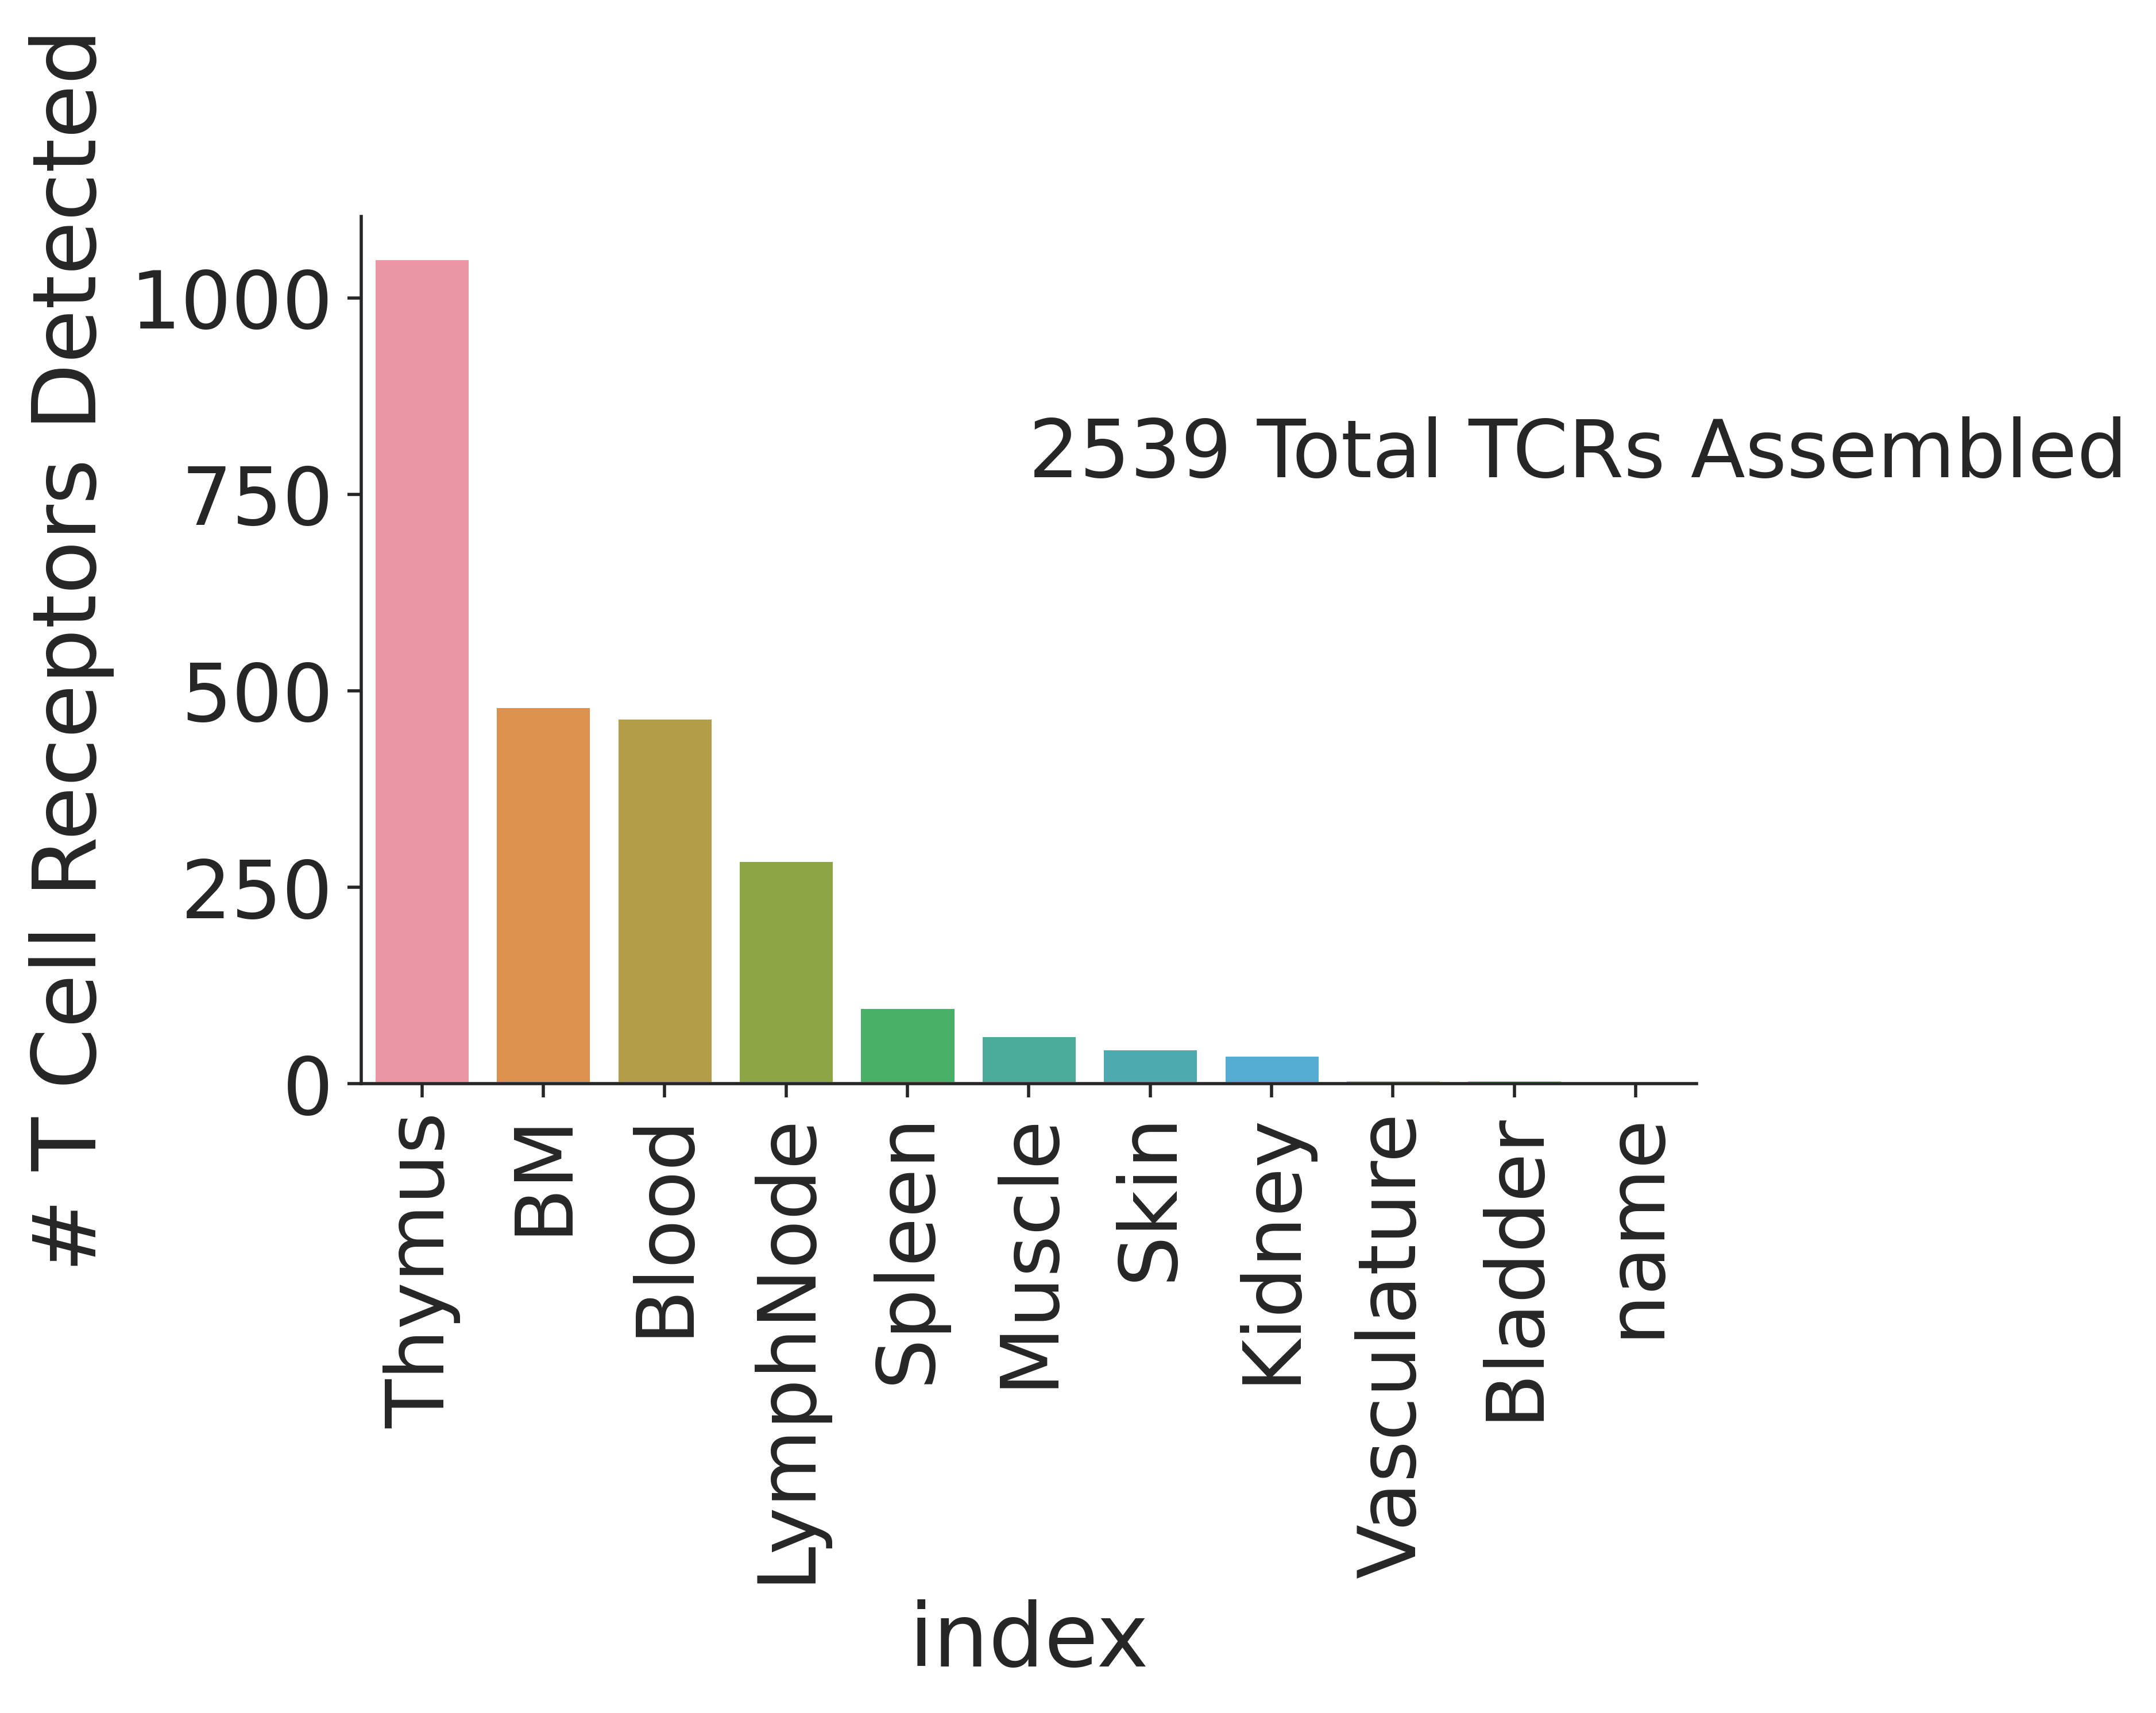

In [20]:
# Bar plot of T cells from different Tissues
_data = TCRs.tissue.value_counts().reset_index()
fig, ax = plt.subplots(1,1)
sns.barplot(x = _data['index'], y = _data['tissue'])
plt.xticks(rotation = 90)
plt.ylabel('# T Cell Receptors Detected')
plt.text(0.5, 0.7, str(_data.tissue.sum()) + " Total TCRs Assembled",  transform=ax.transAxes)
sns.despine()

Text(0, 0.5, 'Events')

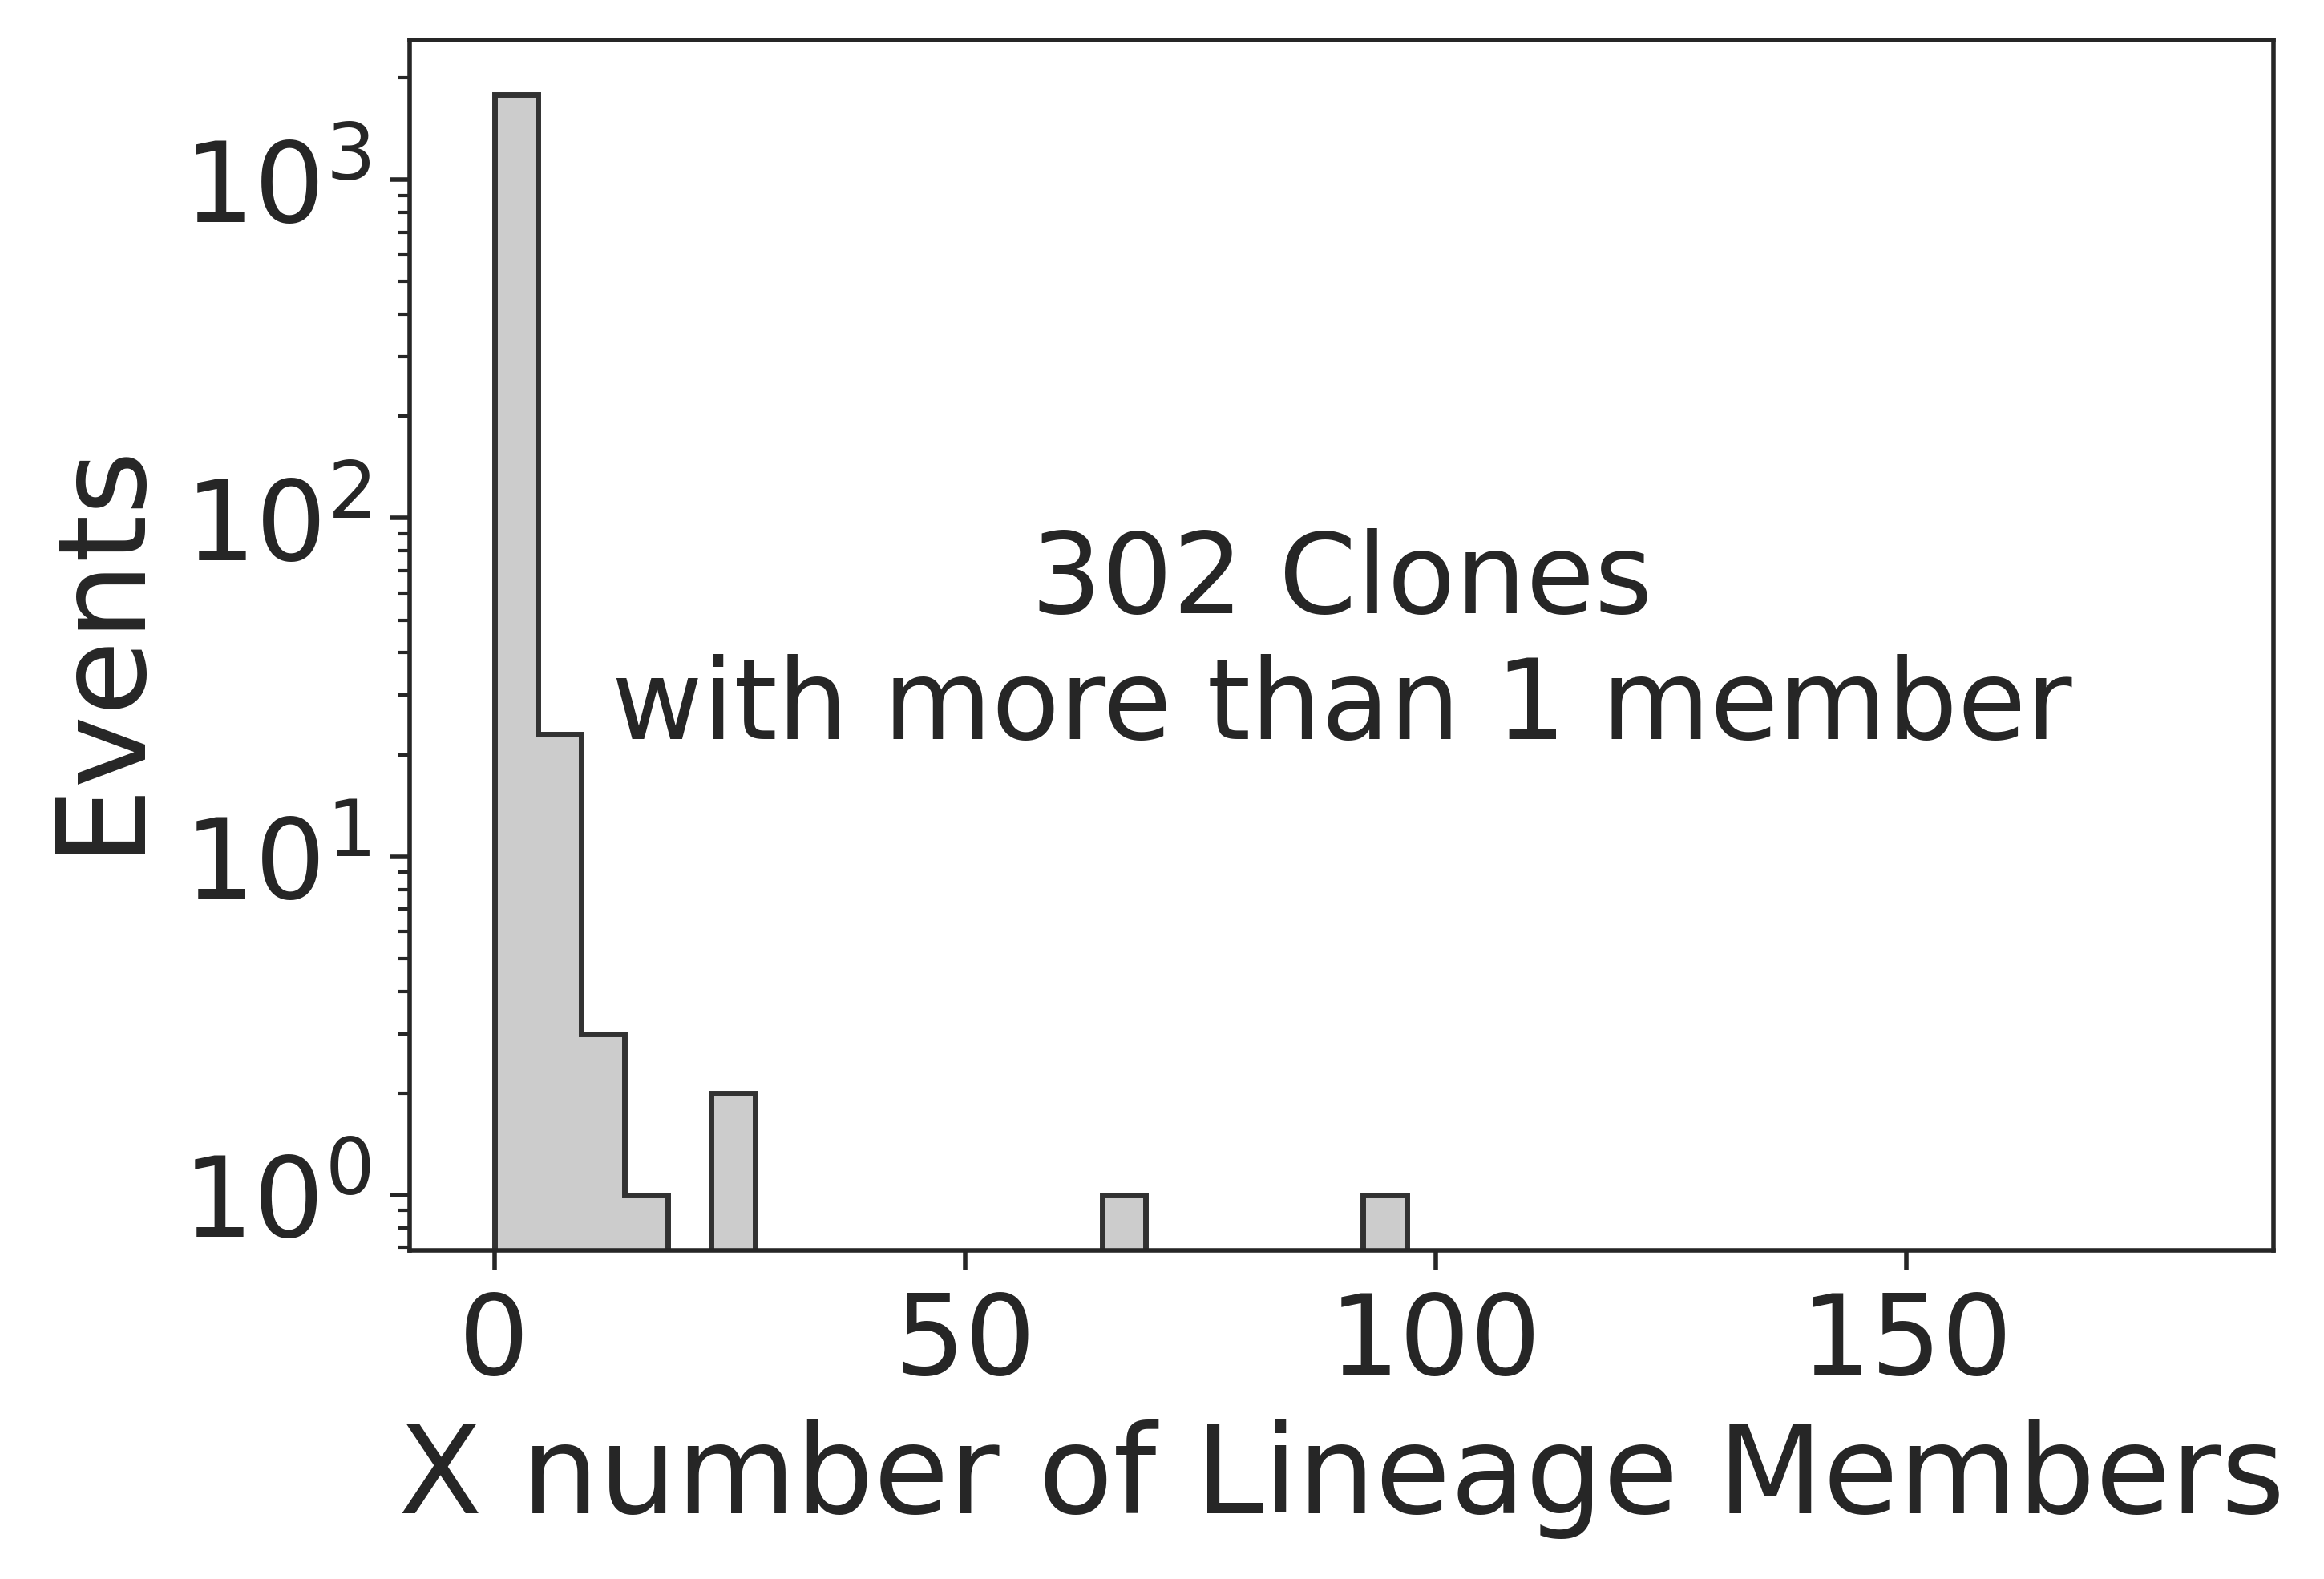

In [21]:
# here's x and y
clones = TCRs.lineage.value_counts().index
counts = TCRs.lineage.value_counts().values
#singles = TCRs.shape[0] - counts.sum()
x = counts
#x = np.append(counts, np.full(singles, 1))

lineages = counts[counts > 1].shape[0]

fig, ax = plt.subplots(1,1)

bins = np.linspace(0, 180, 40)
# step
plt.hist(x, color = 'k', histtype='step', bins = bins)
# filled
plt.hist(x, color = 'k', histtype='stepfilled', alpha = 0.2, bins = bins)
plt.yscale('log')
plt.text(x = 0.5, y = 0.5 , s = str(lineages) + " Clones\nwith more than 1 member", horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
plt.xlabel("X number of Lineage Members")
plt.ylabel("Events")

/home/mswift/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


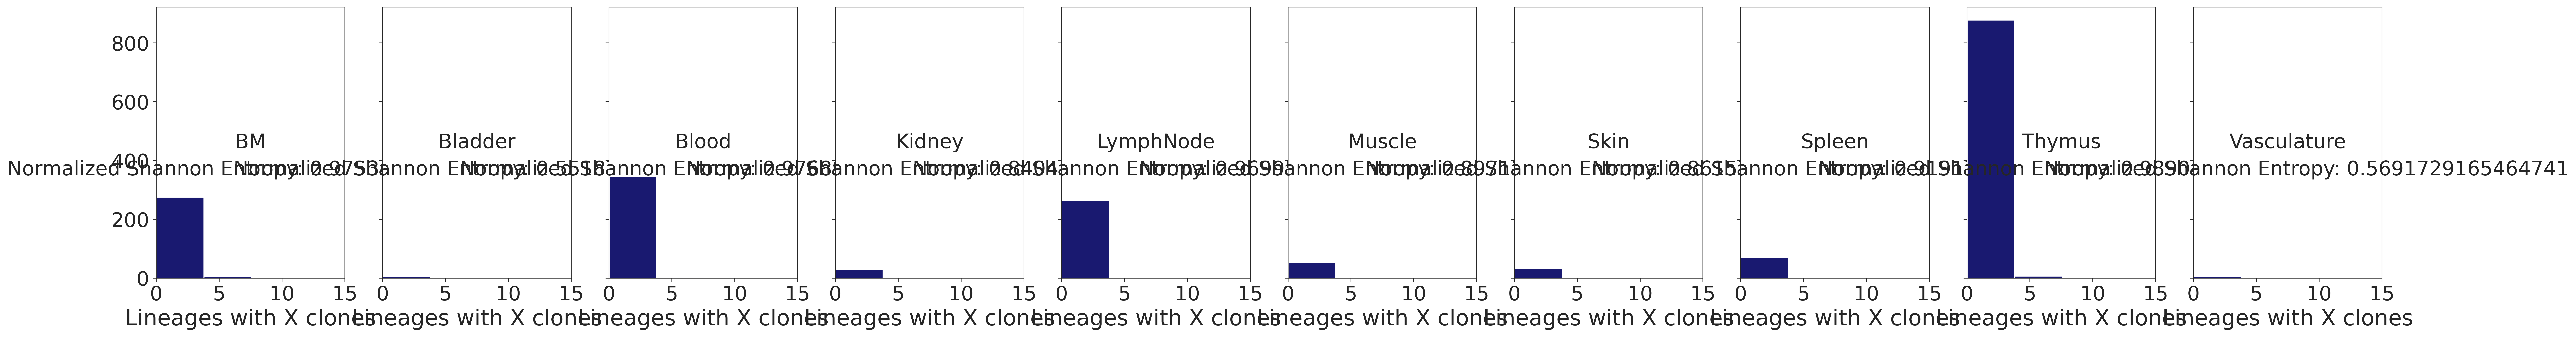

In [22]:
# Steve Mungin'
data = TCRs.groupby('tissue').lineage.value_counts().to_frame()
data.columns = ['counts']
data.reset_index(inplace=True)
titles = data.tissue.unique()

f,a = plt.subplots(1, titles.shape[0], figsize = (40, 5), sharex=True, sharey=True)
a = a.ravel()
bins = np.linspace(0, data.counts.max(), 20)
for idx,ax in enumerate(a):
    x = data.counts[data.tissue == titles[idx]].values
    entropy = stats.entropy(x, base = 2)
    normalized_evenness = 1 - entropy / x.shape[0]
    ax.text(0.5, 0.5, titles[idx],horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.6, 0.4, "Normalized Shannon Entropy: " + str(normalized_evenness), horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    ax.hist(x, bins = bins, color = 'midnightblue')
    #ax.set_title(titles[idx])
    ax.set_xlim(0, 15)
    #ax.set_ylabel('Events')
    ax.set_xlabel('Lineages with X clones')
plt.tight_layout()
    


In [23]:
# Steve Mungin'
data = TCRs.groupby('tissue').lineage.value_counts().to_frame()
data.columns = ['counts']
data.reset_index(inplace=True)
titles = data.tissue.unique()

f,a = plt.subplots(2, 3, figsize = (20, 20), sharex=True, sharey=True)
a = a.ravel()
bins = np.linspace(0, data.counts.max(), 20)
for idx,ax in enumerate(a):
    x = data.counts[data.tissue == titles[idx]].values
    entropy = stats.entropy(x, base = 2)
    normalized_evenness = 1 - entropy / np.log2(x.shape[0])
    normalized_evenness = np.round(normalized_evenness, decimals=2)
    #ax.text(0.5, 0.5, titles[idx],horizontalalignment='center',
     #       verticalalignment='center', transform=ax.transAxes)
    ax.text(0.6, 0.4, "Normalized \n Shannon Entropy: " + str(normalized_evenness), horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes)
    ax.hist(x, bins = bins, color = 'midnightblue')
    ax.set_title(titles[idx])
    ax.set_xlim(0, 15)
    #ax.set_ylabel('Events')
    
    #ax.set_xlabel('Lineages with X clones')
plt.tight_layout()
plt.xlabel('Lineages with X clones')

Text(0.5, 1038.6111111111122, 'Lineages with X clones')

## Selector

In [24]:
selector = TCRs.lineage.value_counts() > 5
selector = selector[selector == True].index

In [25]:
TCR_lineages = TCRs[TCRs.lineage.isin(selector)]

In [252]:
contingency_table = pd.crosstab(TCRs['tissue'], TCRs['lineage'], margins = True)
_data = TCR_lineages
contingency_table_lineages=  pd.crosstab(_data['tissue'], _data['lineage'], margins = False)

In [253]:
contingency_table

lineage      0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  13.0  14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  24.0  25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.0  33.0  34.0  35.0  36.0  37.0  38.0  39.0  40.0  41.0  42.0  43.0  44.0  45.0  46.0  47.0  48.0  49.0  50.0  51.0  52.0  53.0  54.0  55.0  56.0  57.0  58.0  59.0  60.0  61.0  62.0  63.0  64.0  65.0  66.0  67.0  68.0  69.0  70.0  71.0  72.0  73.0  74.0  75.0  76.0  77.0  78.0  79.0  80.0  81.0  82.0  83.0  84.0  85.0  86.0  87.0  88.0  89.0  90.0  91.0  92.0  93.0  94.0  95.0  96.0  97.0  98.0  99.0  100.0  101.0  102.0  103.0  104.0  105.0  106.0  107.0  108.0  109.0  110.0  111.0  112.0  113.0  114.0  115.0  116.0  117.0  118.0  119.0  120.0  121.0  122.0  123.0  124.0  125.0  126.0  127.0  128.0  129.0  130.0  131.0  132.0  133.0  134.0  135.0  136.0  137.0  138.0  139.0  140.0  141.0  142.0  143.0  144.0  145.0  146.0  147.0  148.0  149.0  150.0  151.0  152.0  153.0  154.0  155.0  \
tissue                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
BM             0    0    0    1    0    0    0    0    0    0     0     0     0     0     0     3     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     0     0     0     0     5     1     0     0     0     1     0     0     0     0     0     0     1     0     0     0     0     0     0     0     0     0     1     1     0     0     1     1     0     0     1     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     1     0     0     0     0      0      0      0      2      0      3      4      0     15      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      1     10      0      0      1      0      0      0      0      0      0      1      0      0      0      0      0      0      1      0      0      0      0   
Bladder        0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0     0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0      1      0      0      0      0      0      0      0      0      0      0      0      0      0      0      0   
Blood       

In [254]:
# Expected
expected = contingency_table_lineages.iloc[-1]

In [255]:
contingency_table_lineages

lineage    46.0    105.0   106.0   108.0   134.0   428.0   467.0   507.0   508.0   794.0   968.0   971.0   1093.0  1271.0  1323.0  1417.0  1593.0  1609.0  1633.0
tissue                                                                                                                                                           
BM              5       3       4      15      10      27      72       6      18       0       1       5       2       8       0       1       3       1       0
Blood           2       0       2       1       1      18      21       3       9       0       0       1       4       0       2       0       0       3       1
Kidney          0       2       2       0       0       6       0       0       0       0       0       0       0       0       1       0       0       0       0
LymphNode       0       3       9       0       0       0       0       0       0       0       0       0       0       0       0       2       0       0       0
Muscle          0       1       3       0       0       5       0       0       0       0       1       0       0       0       1       1       0       0       0
Skin            0       0       1       0       0       1       0       0       0       6       0       0       0       0       0       0       0       0       0
Spleen          0       3       5       0       0      11       0       3       0       0       4       0       0       0       2       2       0       0       0
Thymus          0       0       0       0       0       0       1       0       0       0       0       0       0       0       0       0       3       3       5

In [256]:
# Asymptomatic Negative (healthy, OccHealth)
Kidney = contingency_table_lineages.iloc[0][:-1]
f_obs = contingency_table_lineages.values #contingency_table.iloc[2][:9].values)

stat, pval, dof, expected = stats.chi2_contingency(f_obs)

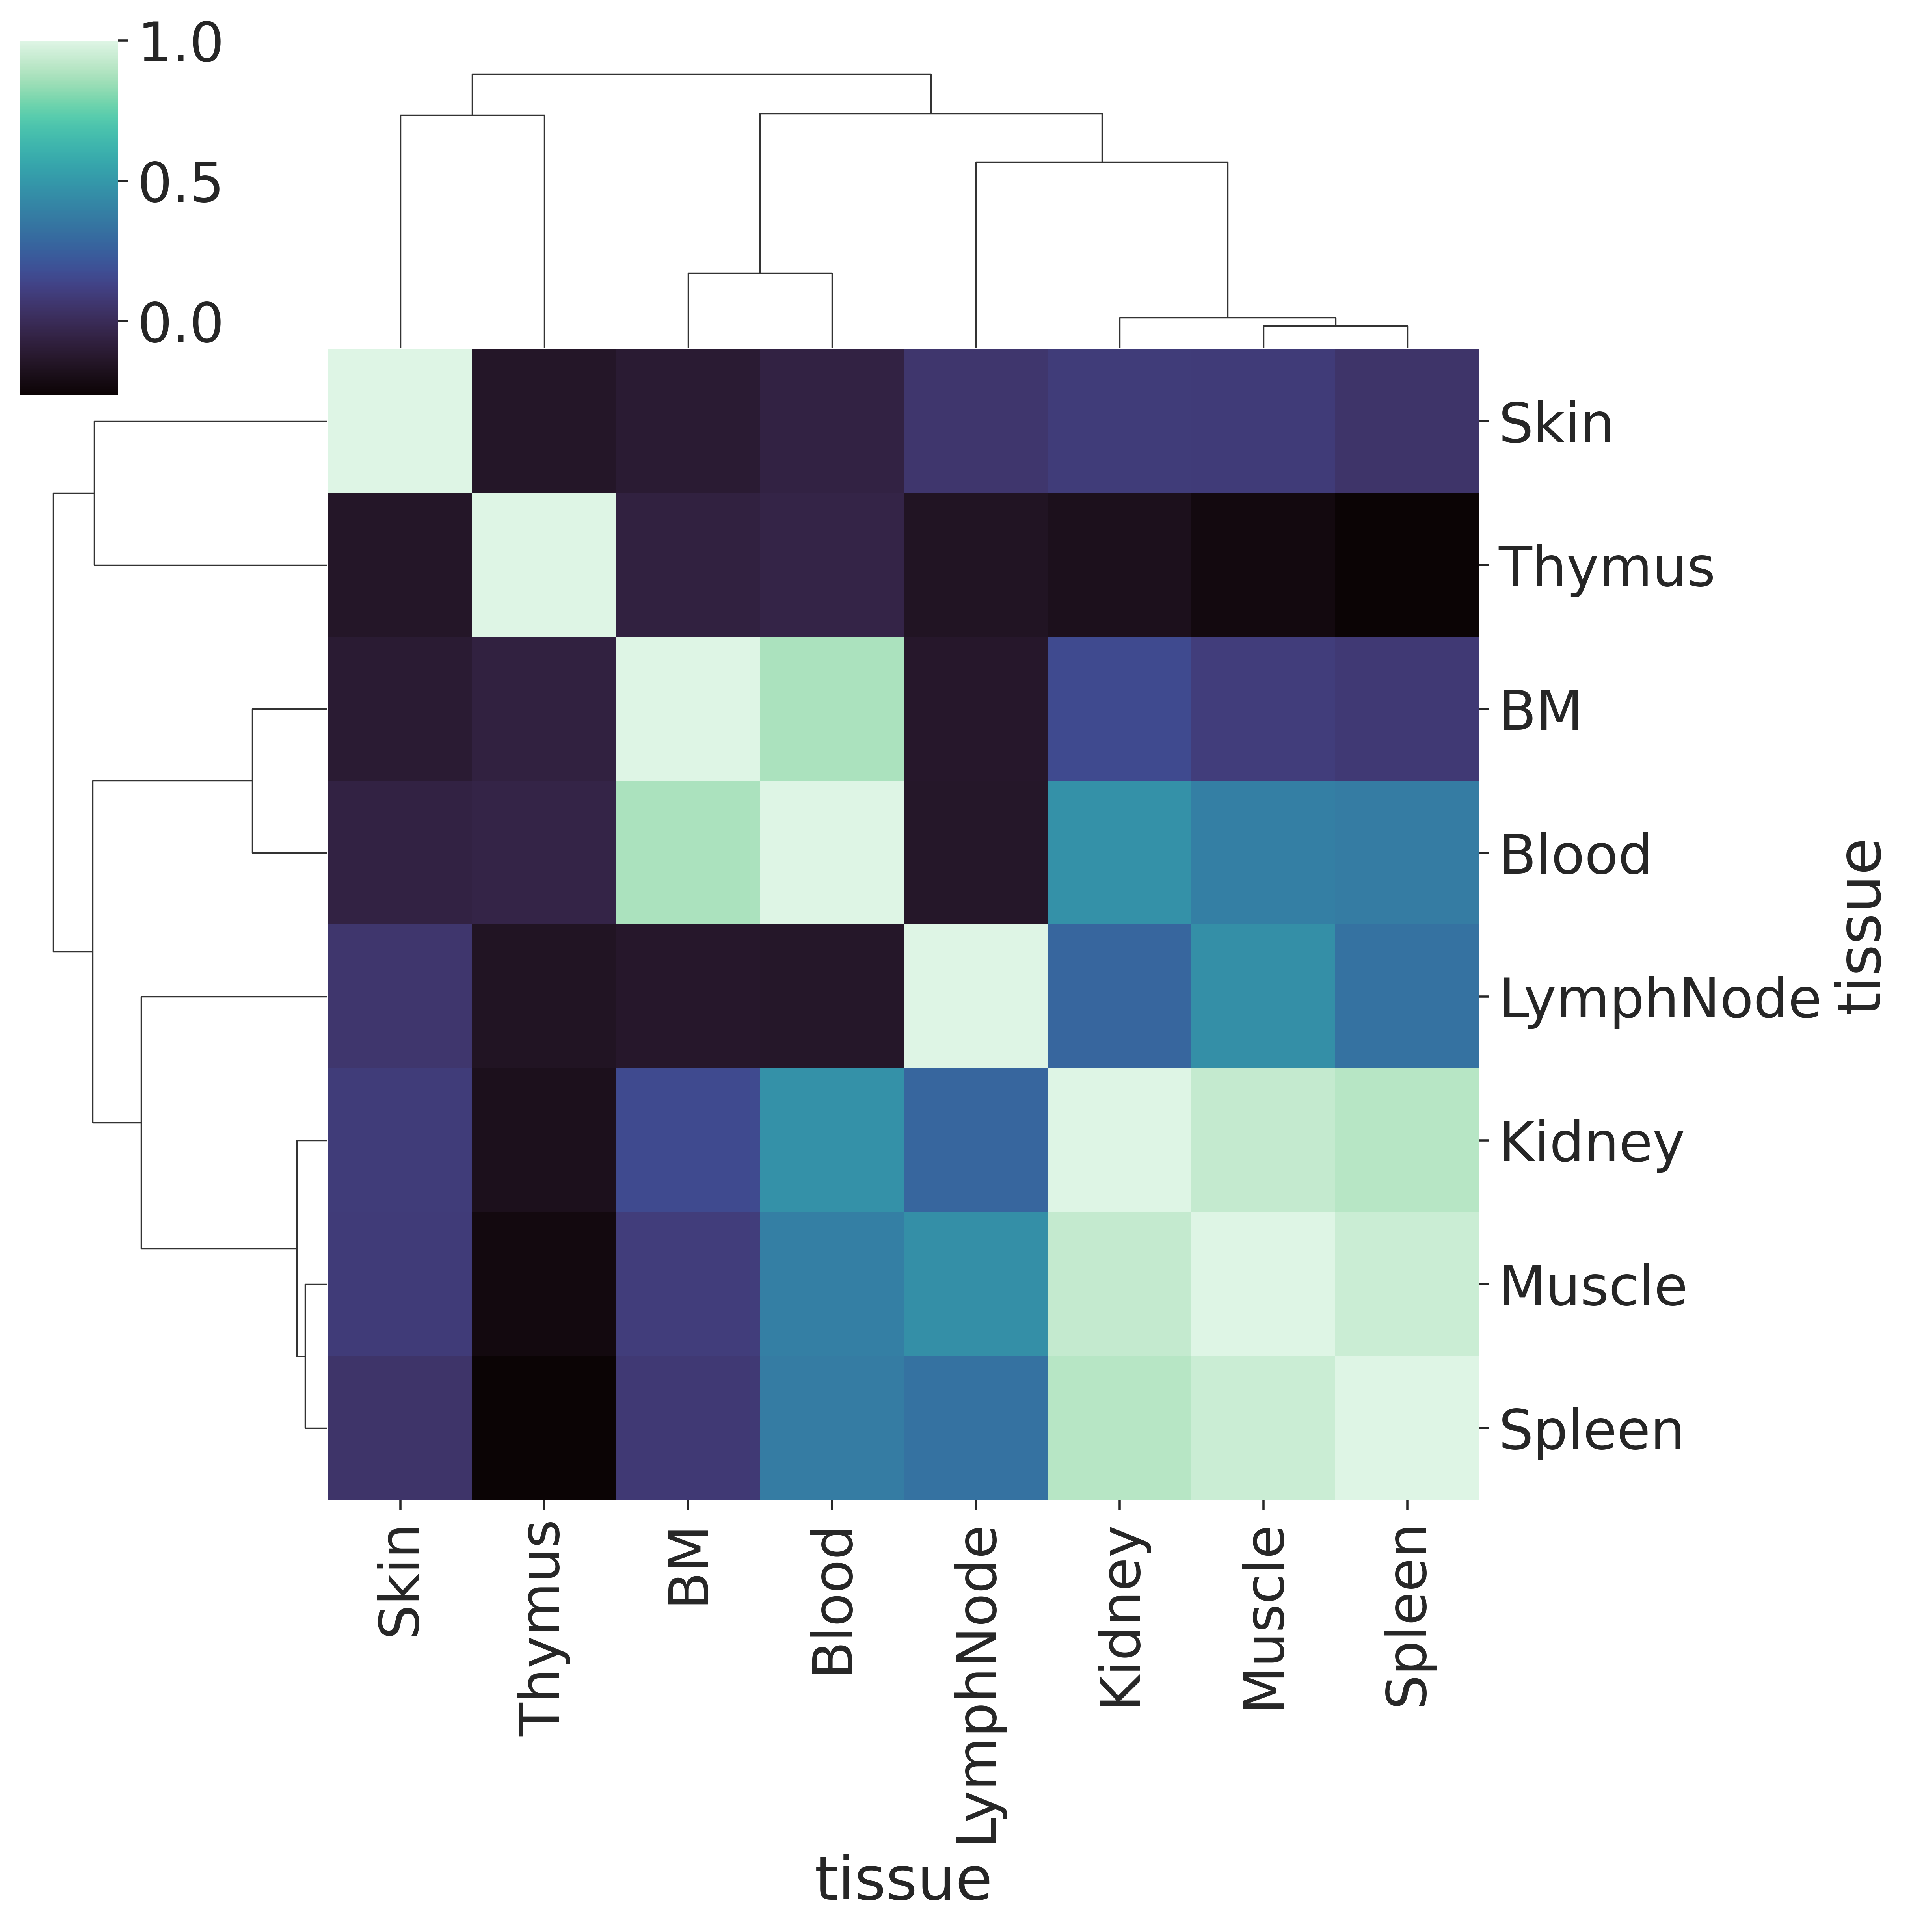

In [272]:
# Contingency table for clones which appear more than once
sns.clustermap(contingency_table_lineages.T.corr(), cmap = 'mako')

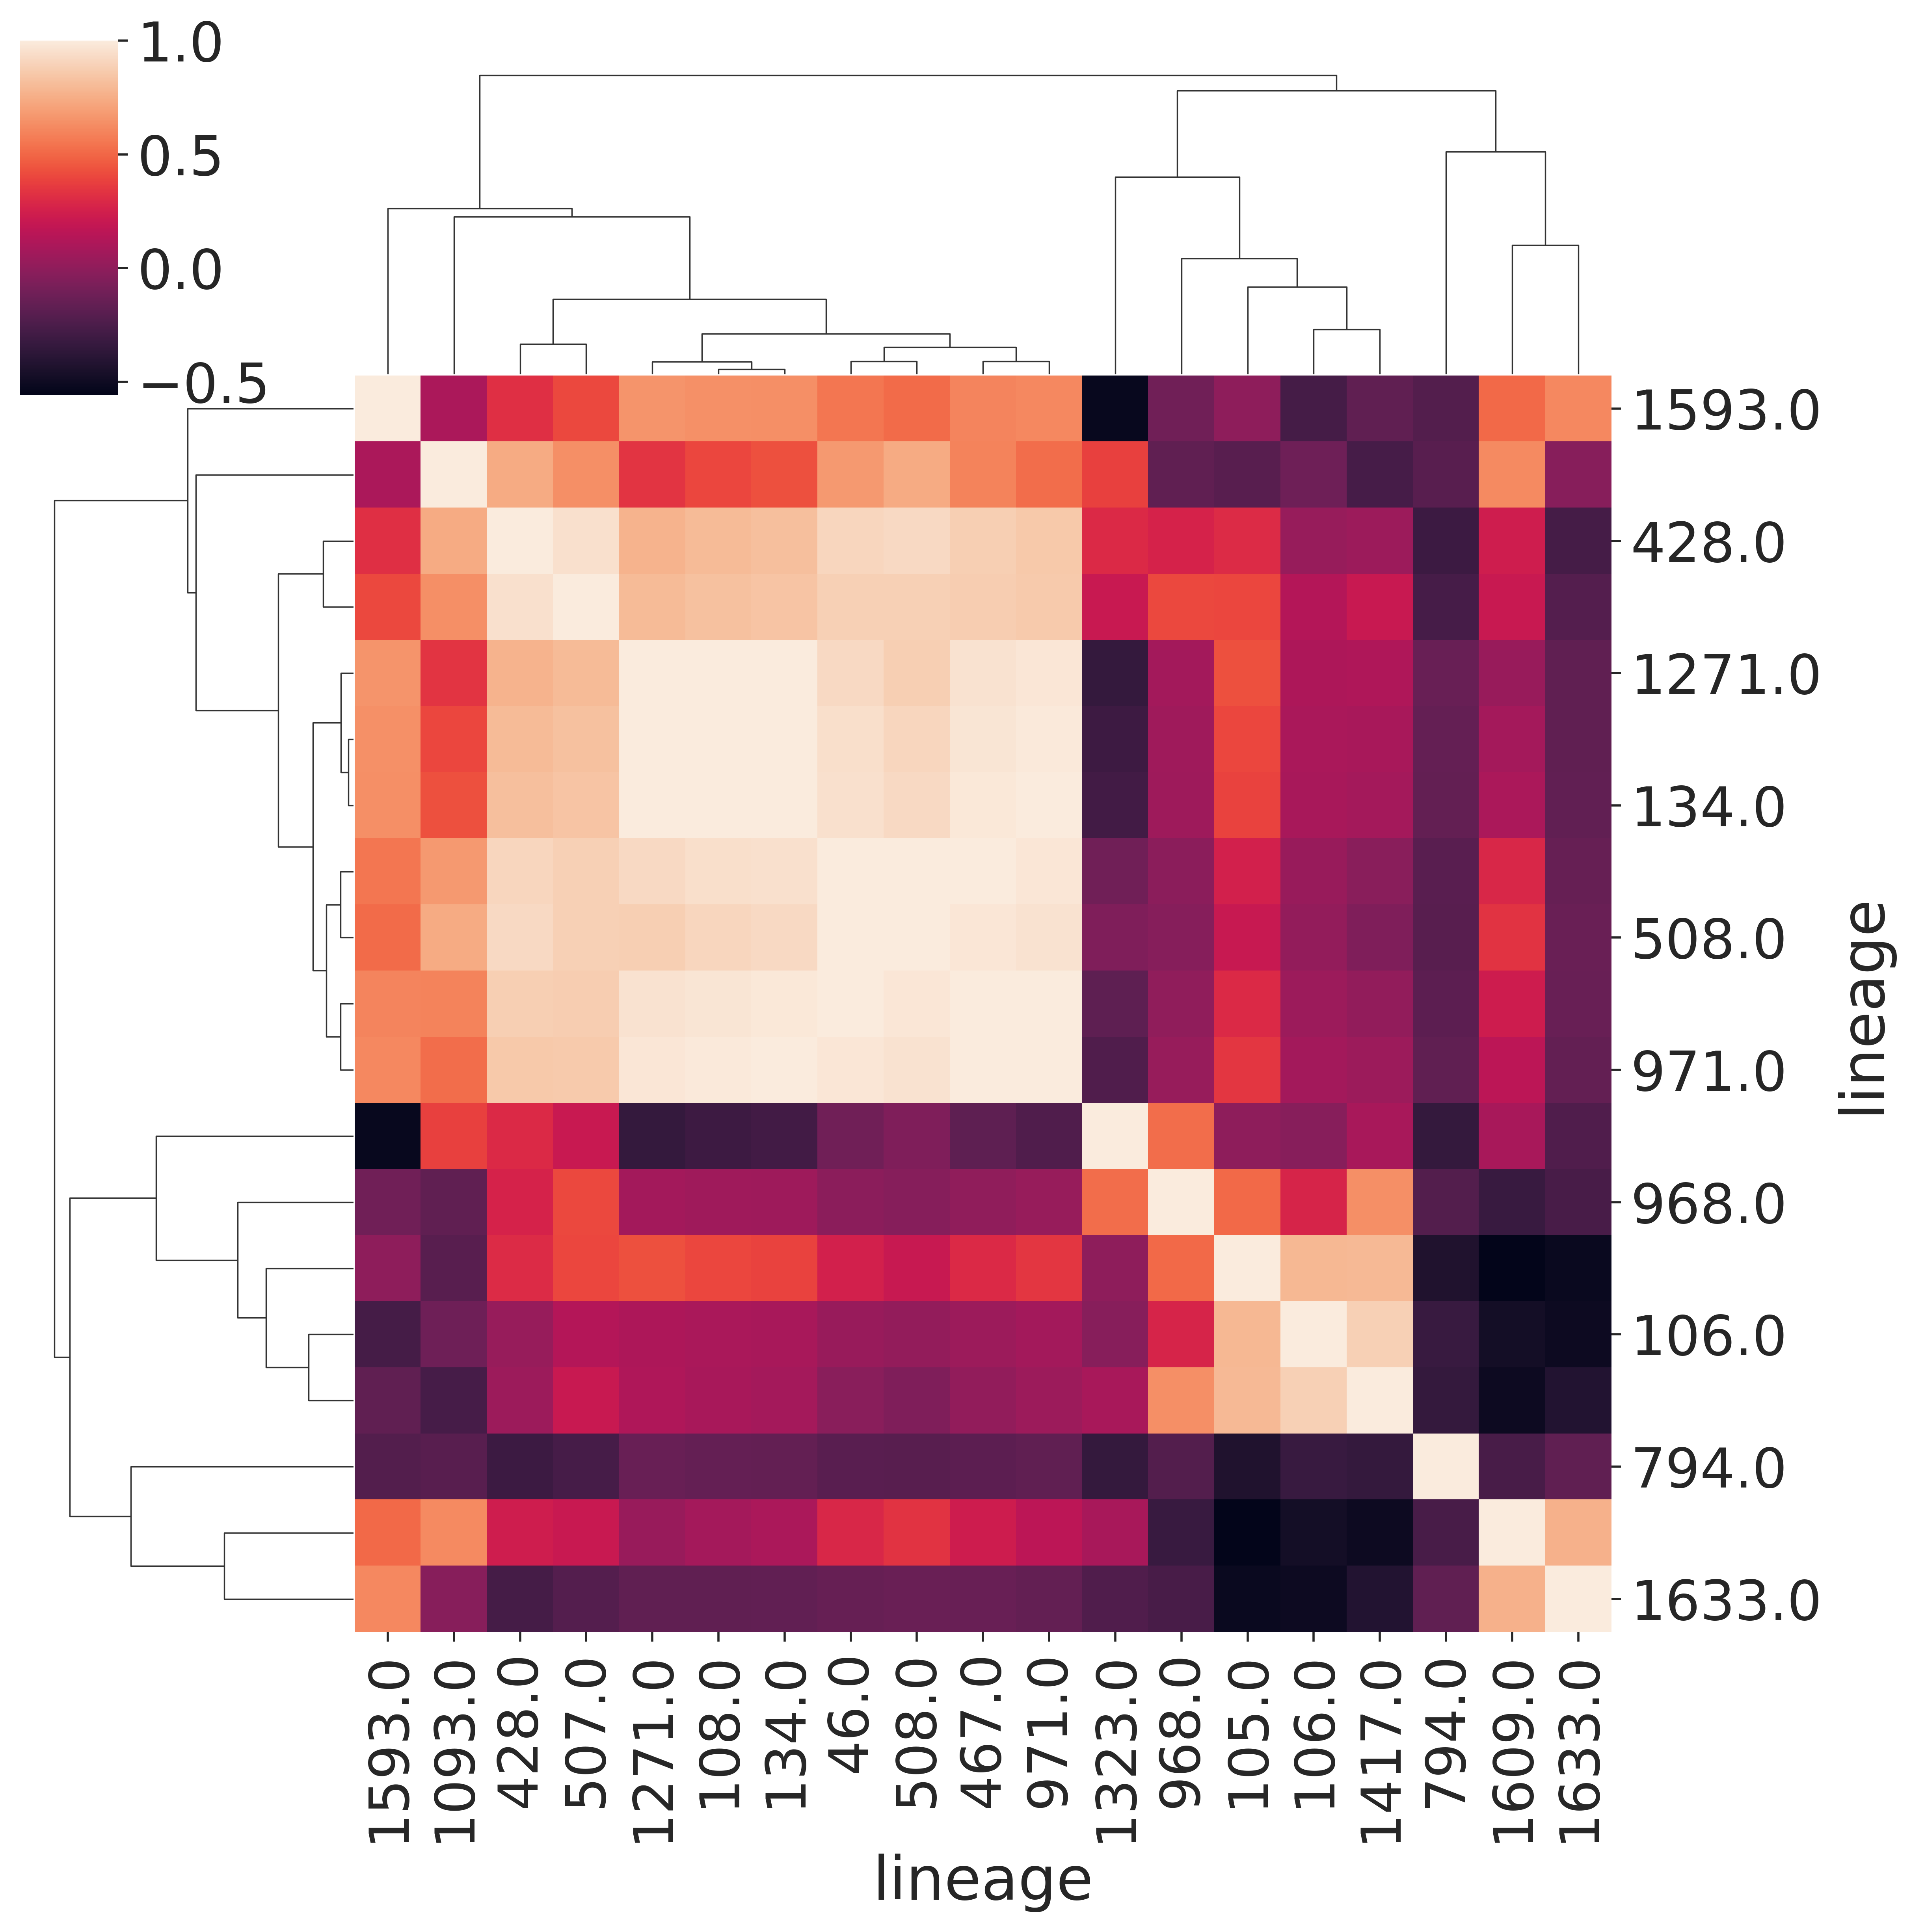

In [262]:
sns.clustermap(contingency_table_lineages.corr())

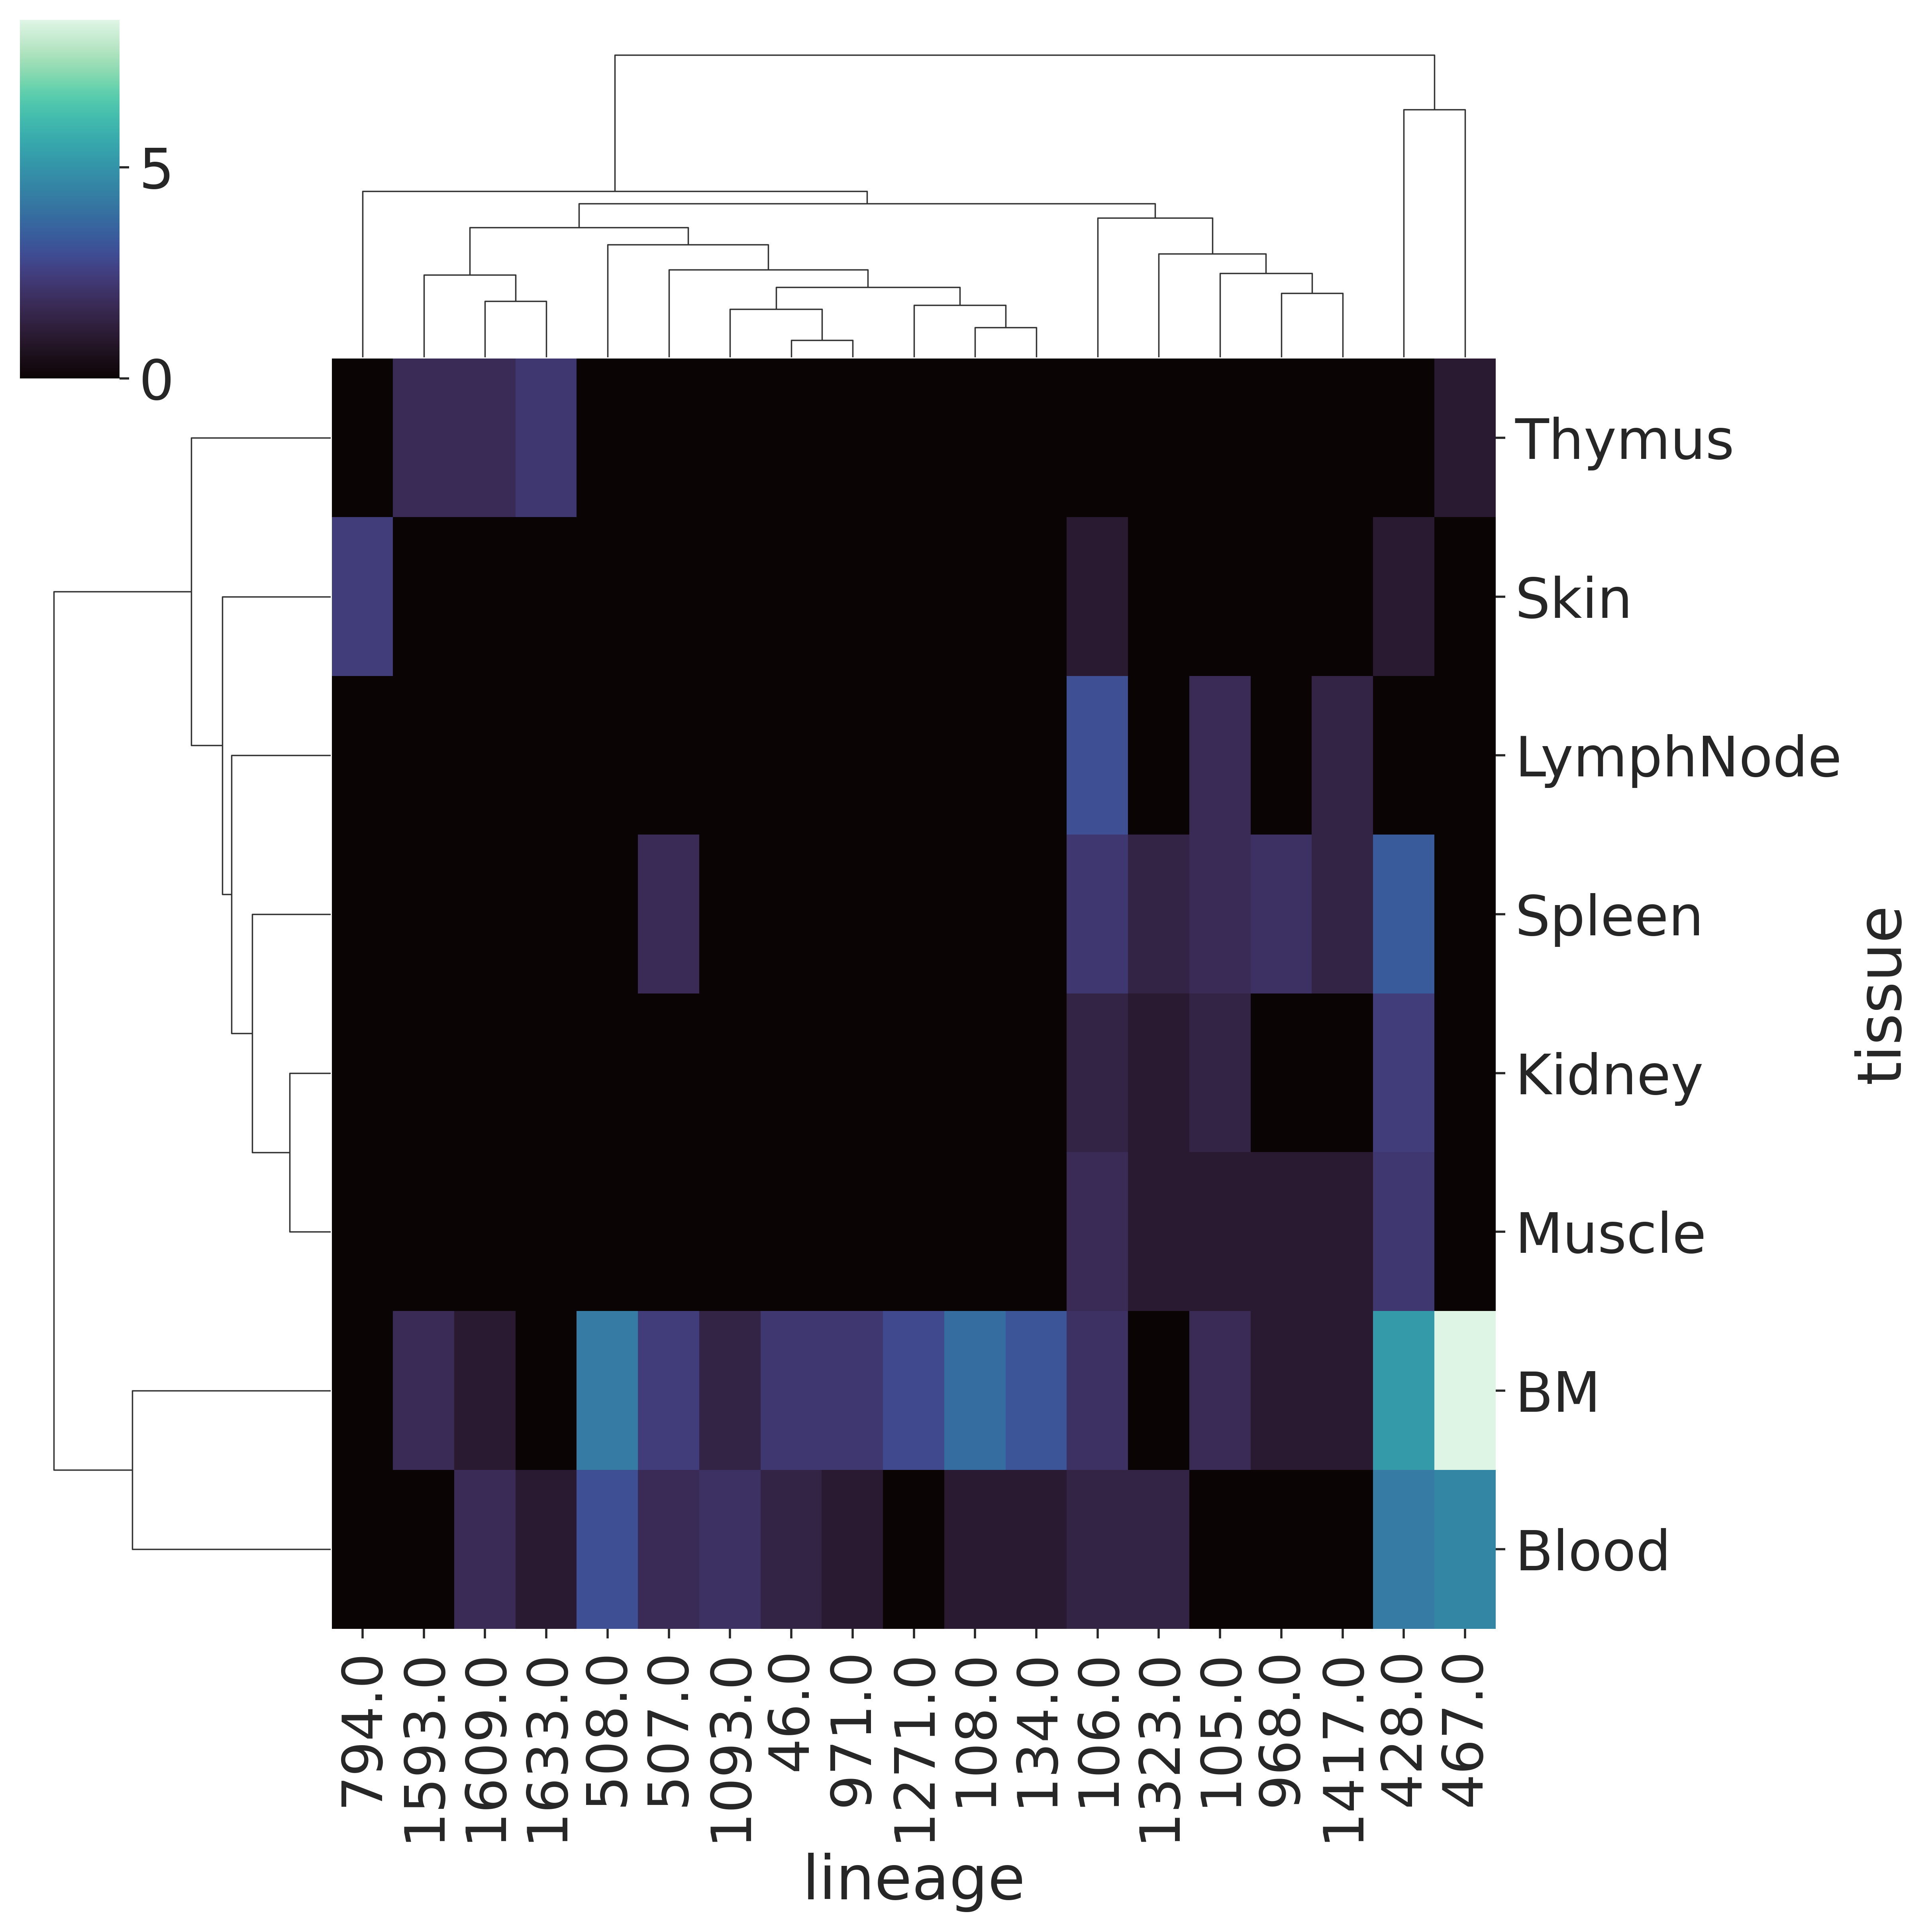

In [271]:
sns.clustermap(np.sqrt(contingency_table_lineages), cmap = 'mako')

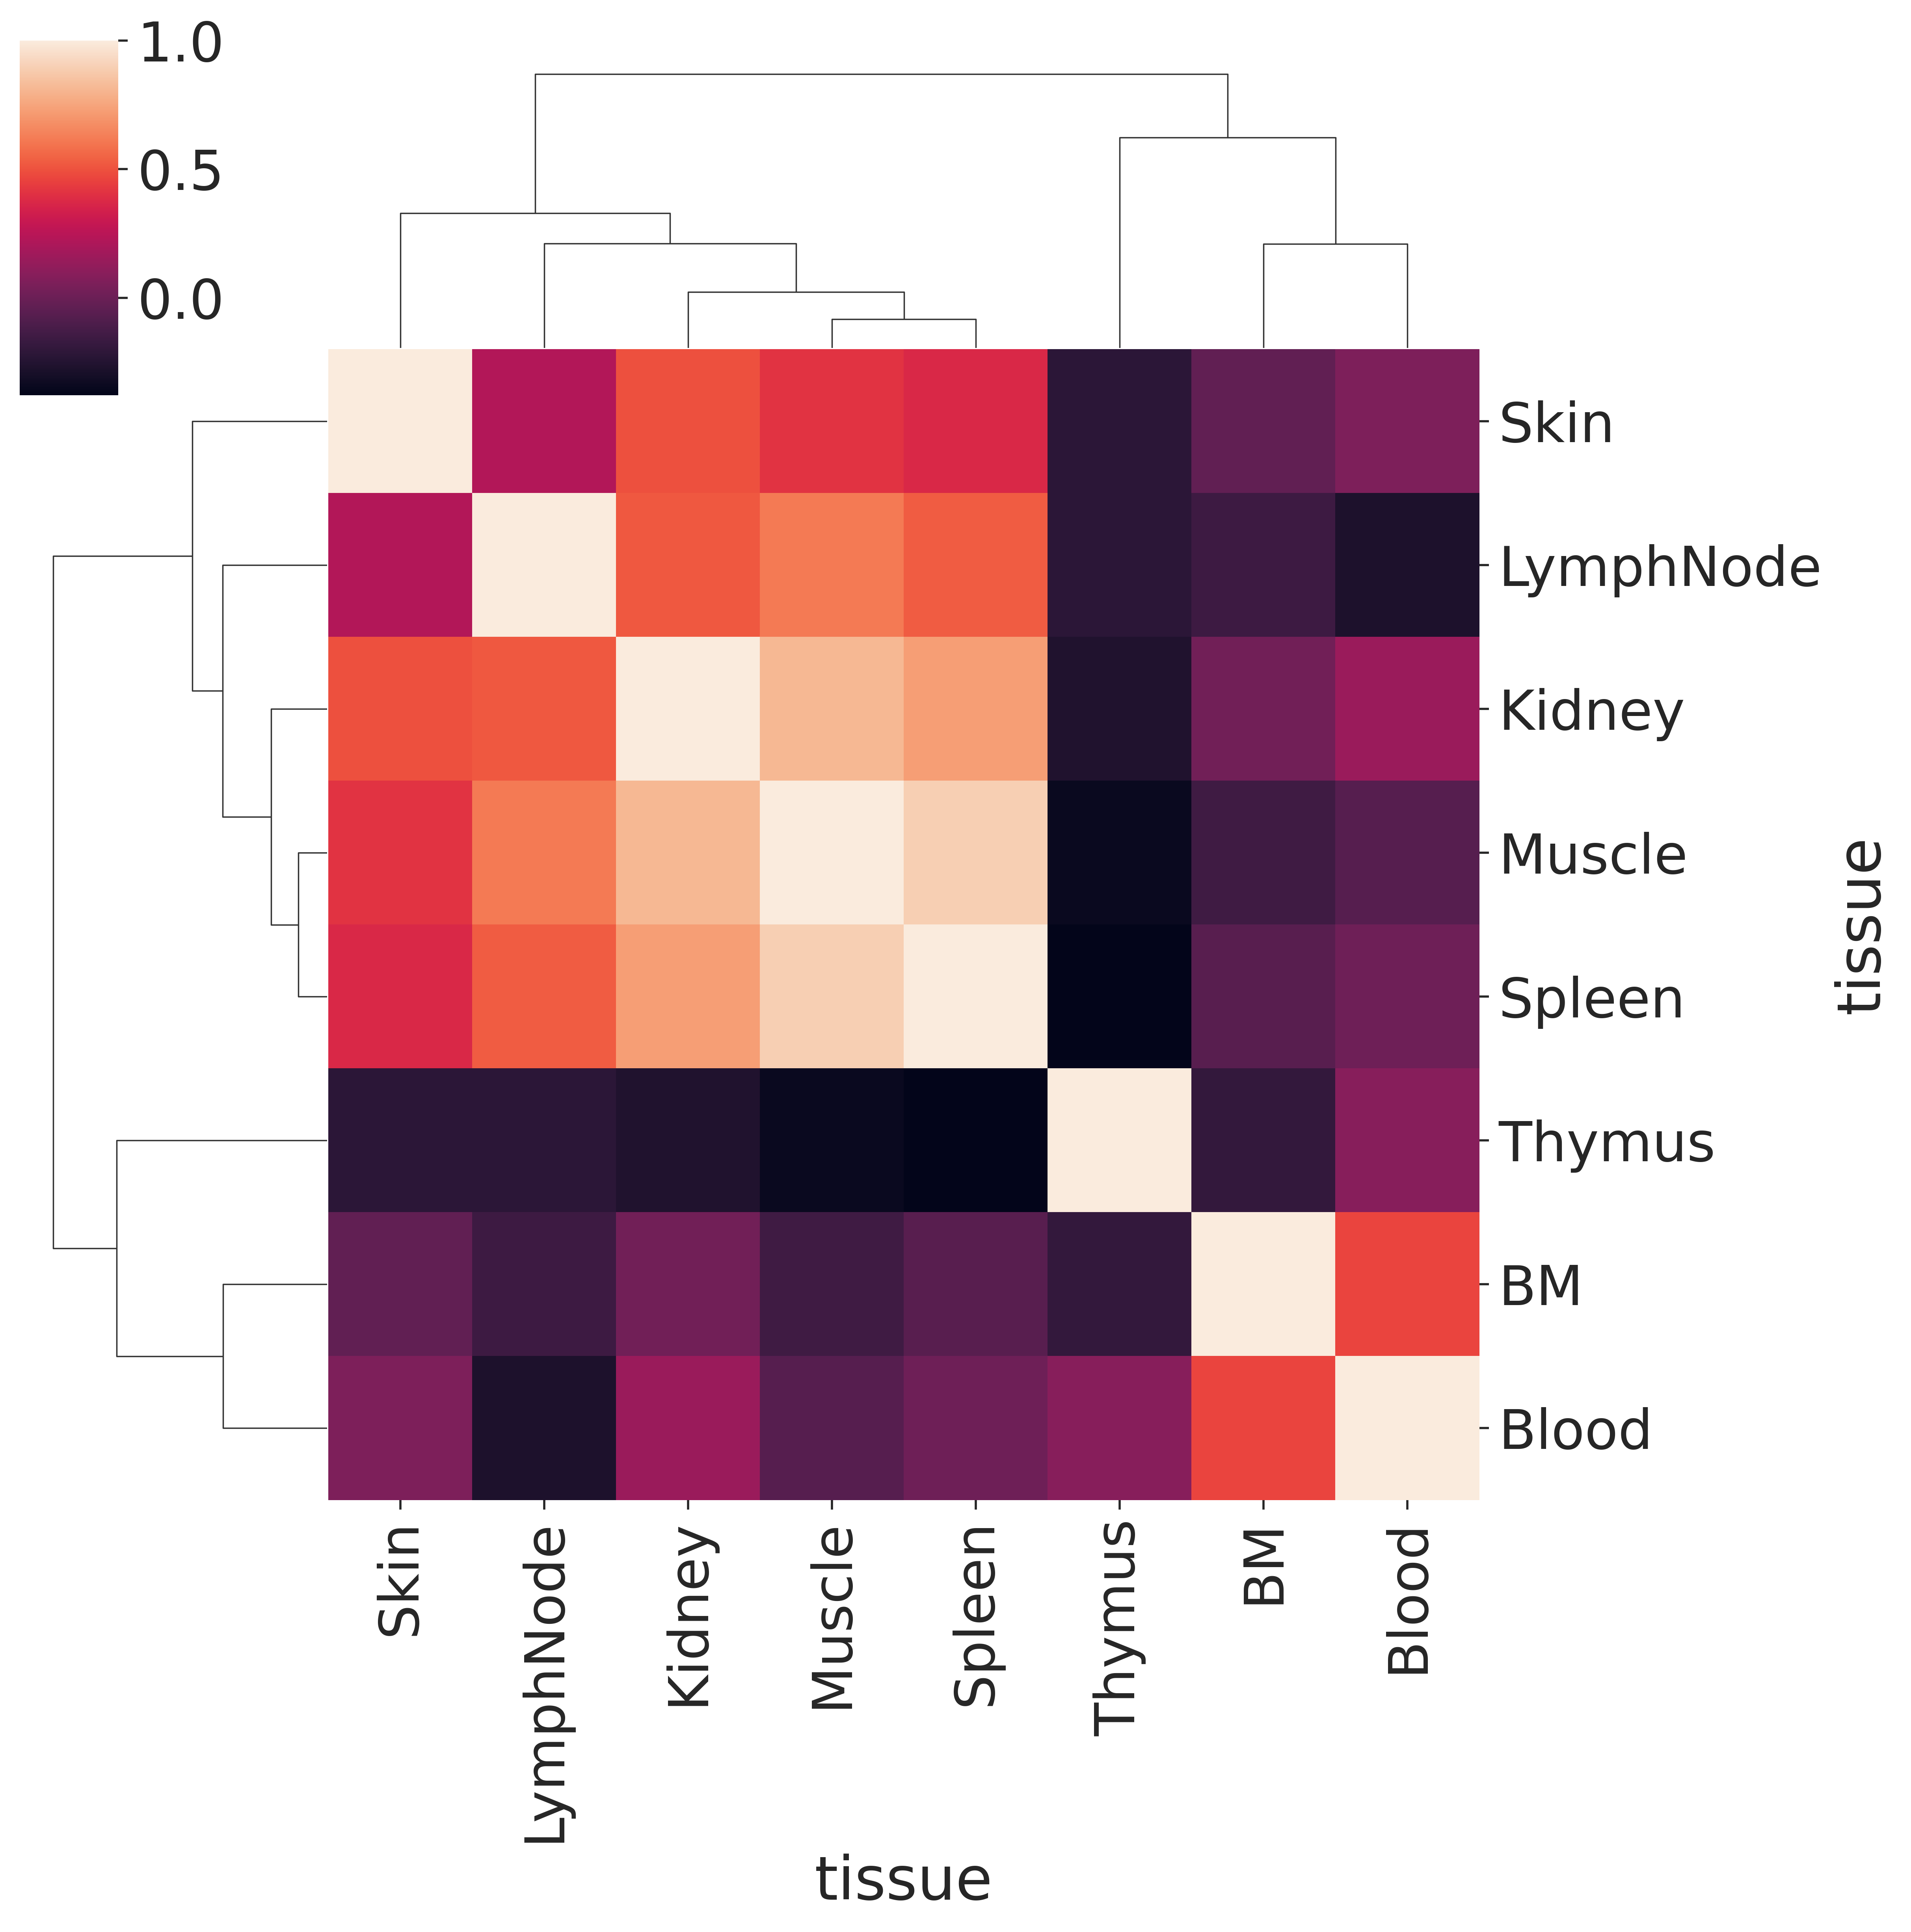

In [266]:
sns.clustermap(contingency_table_lineages.T.corr(method='spearman'))

In [ ]:
_data = TCRs
_contingency_table_lineages = pd.crosstab(_data['SubTissue'], _data['clonal_group'], margins = False)
sns.clustermap(contingency_table_lineages.iloc[:-1,:-1].T.corr())

In [ ]:
# Shannon Entropy of any given Tissue
def calcShannon(series):
    counts = series.value_counts(normalize = True)
    entropy = stats.entropy(counts, base = 2)
    return entropy

In [ ]:
def calcnormShannon(series):
    p = series.value_counts(normalize = True)
    lp = np.log2(p)
    entropy = (lp * p).sum() / p.shape[0] * -1
    return entropy

In [ ]:
TCRs.clonal_group.value_counts(normalize = True)

In [ ]:
calcnormShannon(TCRs.clonal_group)

# Checking shannon entropy is right (it is)
p = TCRs.clonal_group.value_counts(normalize=True)
lp = np.log2(p)
term = p * lp
top = term.sum() * -1

In [431]:
for tissue in TCRs.Tissue.unique():
    data = TCRs[TCRs.Tissue == tissue]
    pk = data.clonal_group.value_counts(normalize = True)
    print(pk)
    entropy = stats.entropy(pk, base=2)
    normalized_evenness = 1 - entropy / pk.shape[0]
    print(tissue, entropy, normalized_evenness) 

0.0       0.128205
6.0       0.128205
18.0      0.076923
34.0      0.025641
2012.0    0.025641
2001.0    0.025641
2002.0    0.025641
2003.0    0.025641
2004.0    0.025641
2005.0    0.025641
2006.0    0.025641
2007.0    0.025641
2008.0    0.025641
2009.0    0.025641
2010.0    0.025641
2011.0    0.025641
2014.0    0.025641
2013.0    0.025641
17.0      0.025641
2015.0    0.025641
2016.0    0.025641
2017.0    0.025641
2018.0    0.025641
2019.0    0.025641
2020.0    0.025641
2021.0    0.025641
2022.0    0.025641
21.0      0.025641
2000.0    0.025641
Name: clonal_group, dtype: float64
Kidney 4.568115848322834 0.8424787638509368
0.0       0.092025
6.0       0.036810
15.0      0.024540
10.0      0.024540
14.0      0.018405
9.0       0.018405
32.0      0.018405
27.0      0.012270
36.0      0.012270
13.0      0.012270
8.0       0.012270
16.0      0.012270
7.0       0.012270
2077.0    0.006135
2107.0    0.006135
2087.0    0.006135
5.0       0.006135
2097.0    0.006135
2117.0    0.006135
17.0     

In [428]:
stats.entropy([1], base = 2)

0.0

In [363]:
contingency_table_lineages = pd.crosstab(_data['Tissue'], _data['clonal_group'], margins = True)


In [372]:
contingency_table_lineages.iloc[-1, :37].sum()

170

# Sub Sampling

In [401]:
df = TCRs[TCRs.Tissue != 'Lung']

In [402]:
df = df.groupby('Tissue').apply(pd.DataFrame.sample, n = 39).reset_index(drop = True)

In [403]:
_data = df
_contingency_table_lineages = pd.crosstab(_data['Tissue'], _data['clonal_group'], margins = False)


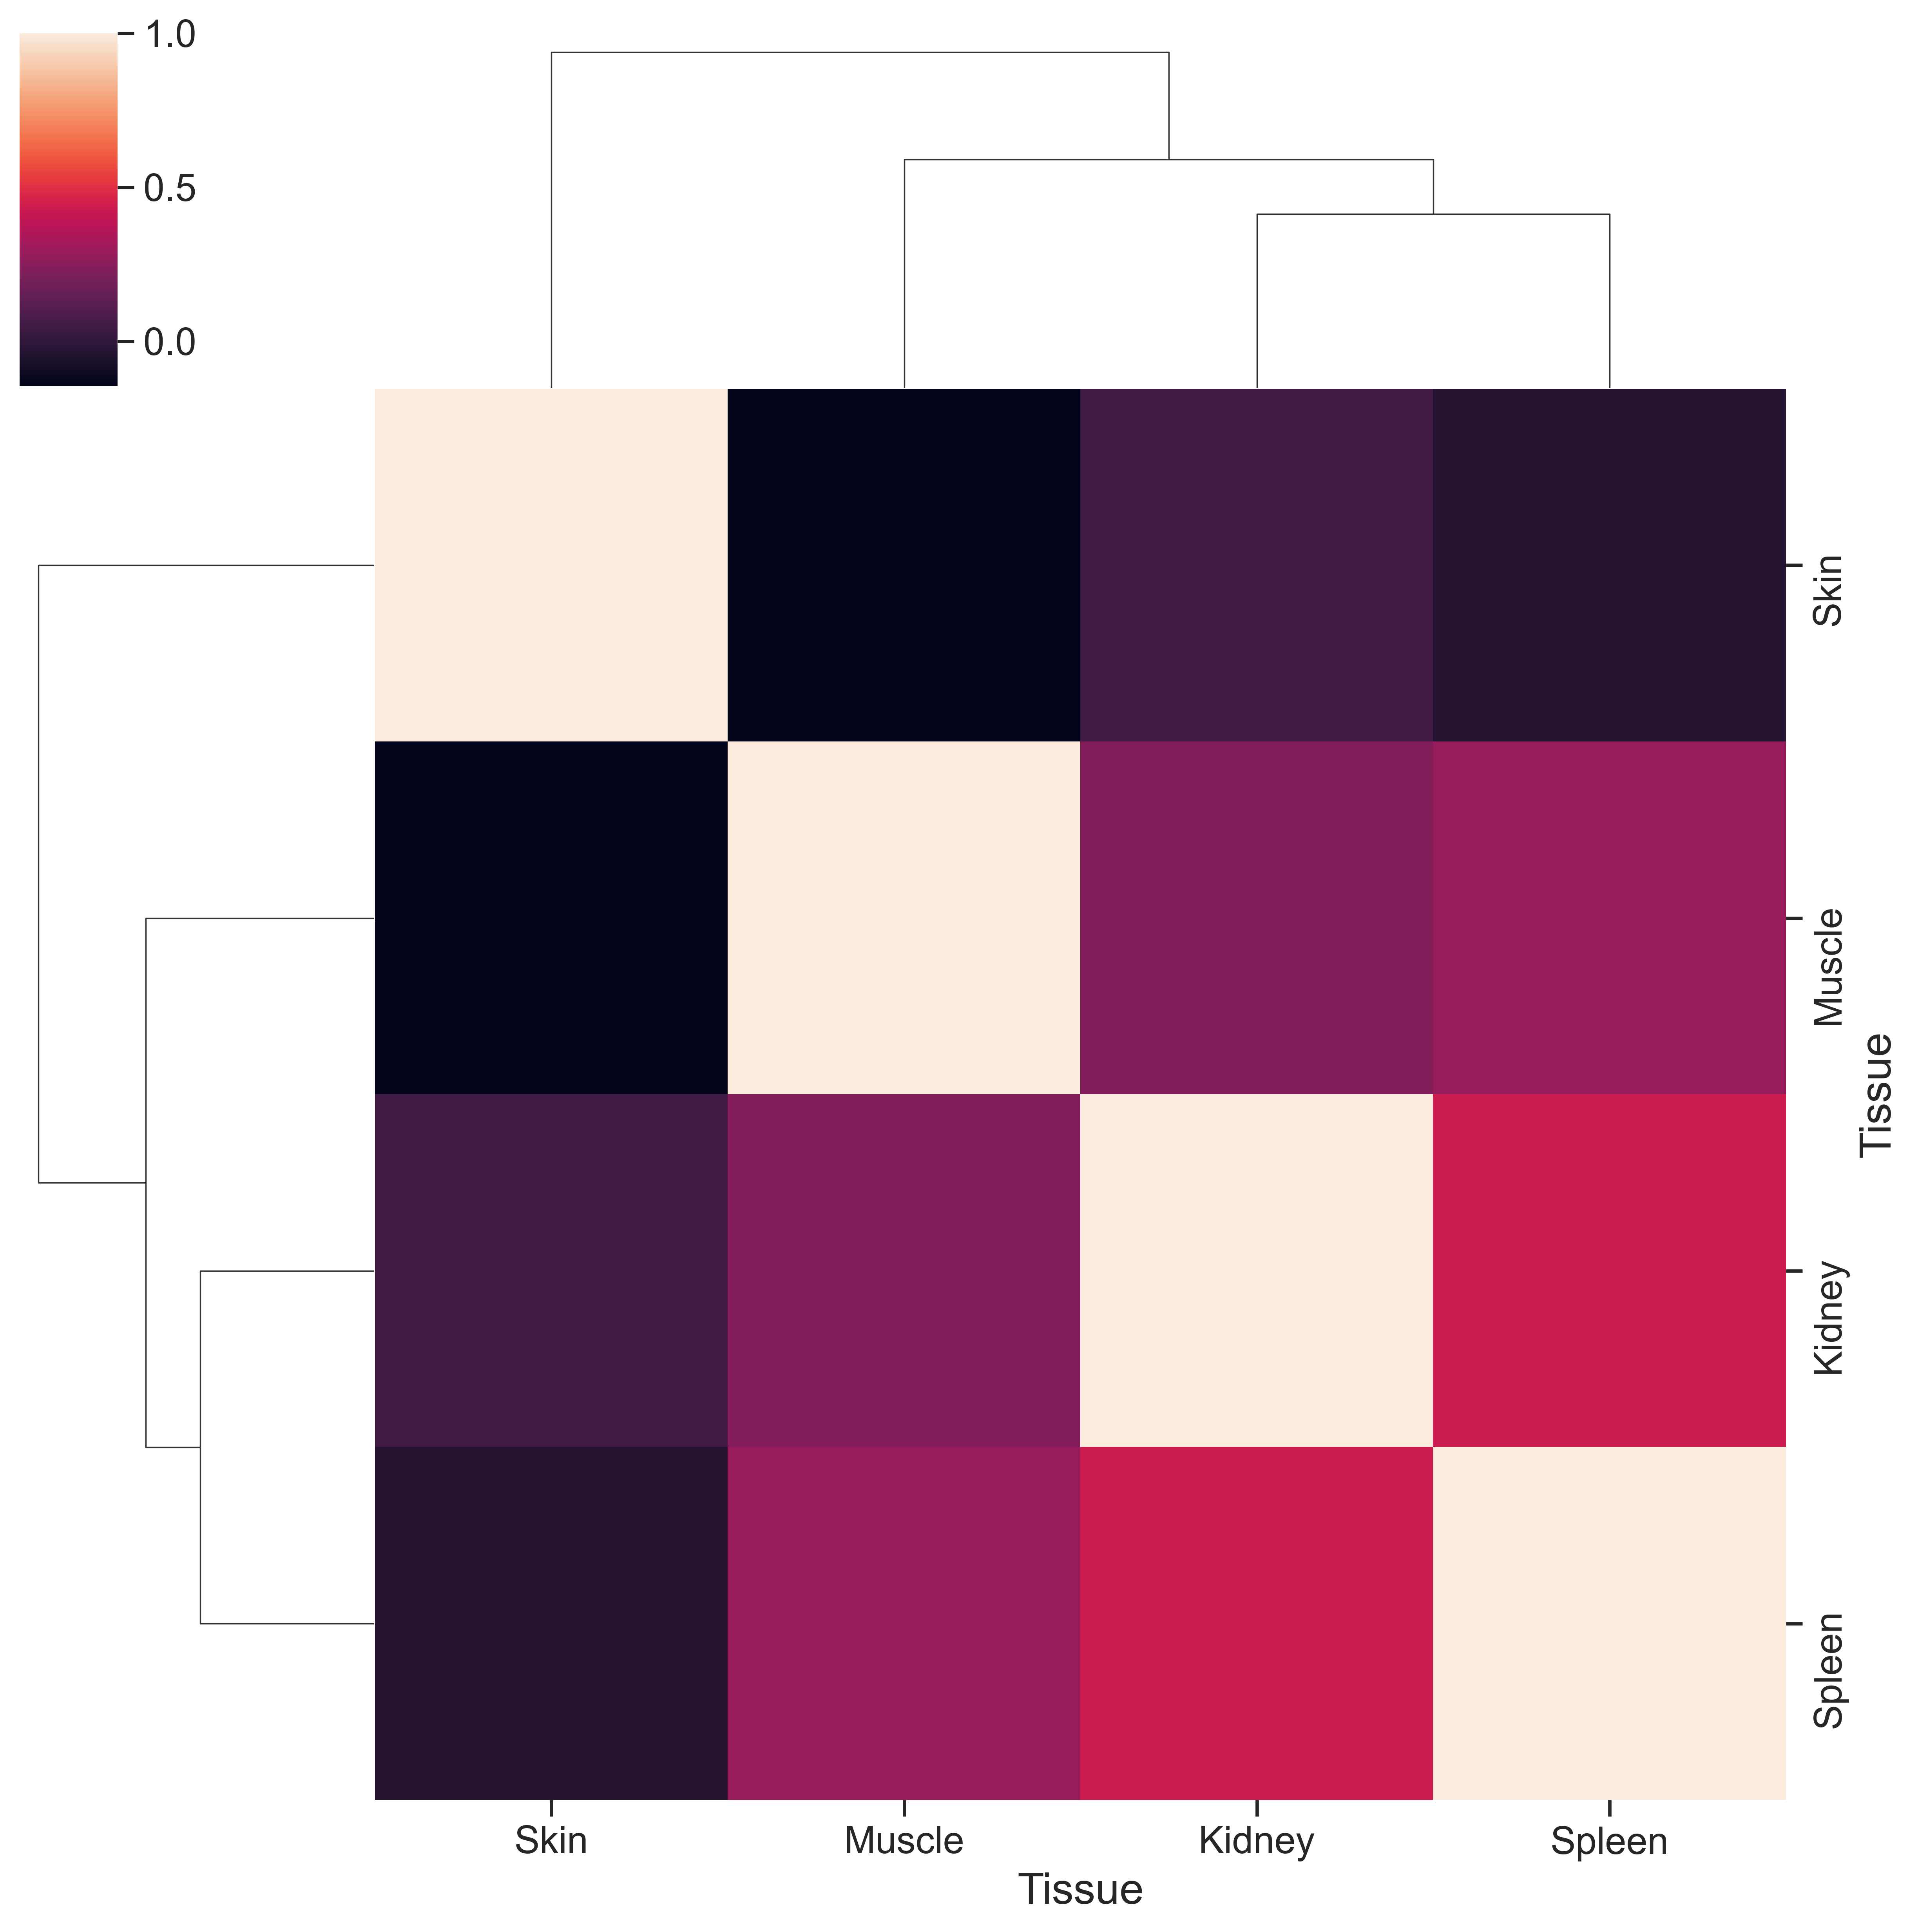

In [408]:

sns.clustermap(_contingency_table_lineages.T.corr())

In [451]:
for tissue in df.Tissue.unique():
    data = df[df.Tissue == tissue]
    entropy = calcShannon(data.clonal_group)
    normalized_evenness = 1 - entropy / np.log2(data.shape[0])
    normalized_evenness = np.round(normalized_evenness, decimals=2)
    print(tissue, entropy, normalized_evenness)

Kidney 4.568115848322834 0.14
Muscle 5.080274013734042 0.04
Skin 5.009635872652929 0.05
Spleen 4.7632348348468545 0.1


In [447]:
x = TCRs.clonal_group.value_counts(normalize=True)
entropy = stats.entropy(x, base = 2)
normalized_evenness = 1 - entropy / np.log2(x.shape[0])
normalized_evenness = np.round(normalized_evenness, decimals=2)

In [273]:
TCRs

cell_name chain                            value v_call_no_allele                                      cdr3nt j_call_no_allele  None  cdr3nt_len Donor  tissue Anatomy Chemistry      BC1      BC2         Annotation Well S_number is_cell                    contig_id high_confidence  length      v_gene d_gene  j_gene c_gene full_length productive            cdr3                                     cdr3_nt    reads  umis raw_clonotype_id          raw_consensus_id                           metadata  lineage
0     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...   TRA     TRAV12-2_CGTGATGTCAGA_TRAJ16           TRAV12                                CGTGATGTCAGA           TRAJ16  None          12  TSP2  Kidney      NA       SS2  B114662  B104860  TubularEpithelial   A1       S1     NaN                          NaN             NaN     NaN         NaN    NaN     NaN    NaN         NaN        NaN             NaN                                         NaN      NaN   NaN              NaN                       NaN                                NaN    105.0
1     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...   TRA     TRAV5_GAGAGGCGCGATTCC_TRAJ41            TRAV5                             GAGAGGCGCGATTCC           TRAJ41  None          15  TSP2  Kidney      NA       SS2  B114662  B104860  TubularEpithelial   A4       S4     NaN                          NaN             NaN     NaN         NaN    NaN     NaN    NaN         NaN        NaN             NaN                                         NaN      NaN   NaN              NaN                       NaN                                NaN   1435.0
2     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...   TRA     TRAV16_CTGAGCCGAGCTGG_TRAJ52           TRAV16                              CTGAGCCGAGCTGG           TRAJ52  None          14  TSP2  Kidney      NA       SS2  B114662  B104860  TubularEpithelial   A6       S6     NaN                          NaN             NaN     NaN         NaN    NaN     NaN    NaN         NaN        NaN             NaN                                         NaN      NaN   NaN              NaN                       NaN                                NaN    510.0
3     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...   TRA  TRAV6_GCTCTCGGGGGCTTATCAG_TRAJ6            TRAV6                         GCTCTCGGGGGCTTATCAG            TRAJ6  None          19  TSP2  Kidney      NA       SS2  B114662  B104860  TubularEpithelial   B2      S26     NaN                          NaN             NaN     NaN         NaN    NaN     NaN    NaN         NaN        NaN             NaN                                         NaN      NaN   NaN              NaN                       NaN                                NaN   1478.0
4     TSP2_Kidney_NA_SS2_B114662_B104860_TubularEpit...   TRA    TRAV1-2_TGCTGGGGCGTTTT_TRAJ16            TRAV1                              TGCTGGGGCGTTTT           TRAJ16  None          14  TSP2  Kidney      NA       SS2  B114662  B104860  TubularEpithelial   B3      S27     NaN                          NaN             NaN     NaN         NaN    NaN     NaN    NaN         NaN        NaN             NaN                                         NaN      NaN   NaN              NaN                       NaN                                NaN     14.0
...                                                 ...   ...                              ...              ...                                         ...              ...   ...         ...   ...     ...     ...       ...      ...      ...                ...  ...      ...     ...                          ...             ...     ...         ...    ...     ...    ...         ...        ...             ...                                         ...      ...   ...              ...                       ...                                ...      ...
5162                                 TTGGCAATCAACTCTT-1   TRA                              NaN           TRAV38        TGTGCTTTCACAGGCGGATCTGAAAAGCTGGTCTTT           TR

In [26]:

from numpy.random import seed


def df_generate_node_dict(frame, singletons=False):
    """ Generates a node property dictionary for downstream graph-tool plotting
        Args:
            frame (pd.Dataframe) with the following columns:
                - lineage (mandatory)
                - node_color (optional)
                - node_shape (optional)
                - node_size (optional)
                - node_stroke (optional)
            singletons (bool): whether to include cells that do not form
                multi-member clonal families
        Returns:
            dict: nested as follows: {node_id: {'property1': 'value1', ...}}
    """
    frame = frame.copy()

    # use some defaults if property columns are missing
    req_key_defaults = {'node_color': 'blue',
                        'node_shape': 'circle',
                        'node_size': 1,
                        'node_stroke': 0.5}
    for key, default in req_key_defaults.items():
        if key not in frame.columns:
            frame[key] = default  # add column to dataframe

    node_props = {}
    node_id = 0
    for lin, g in frame.groupby('lineage'):
        if g.shape[0] > 1 or singletons:
            if g.shape[0] > 1:
                # add a germline to root all cells in a lineage
                gid = node_id
                node_props[gid] = {'color': 'k',
                                   'ancestor': None,
                                   'size': frame['node_size'].min(),
                                   'shape': 'circle',
                                   'stroke': 0}
                node_id += 1
            else:
                # no germline root for a singleton
                gid = None

            # add cell(s) with properties
            for _, row in g.iterrows():
                node_props[node_id] = {'ancestor': gid,
                                       'color': row['node_color'],
                                       'shape': row['node_shape'],
                                       'size': row['node_size'],
                                       'stroke': row['node_stroke']
                                       }
                node_id += 1

    return node_props


def draw_gviz(node_dict, size_multiple=50, random_seed=42, **kwargs):
    """ Draw clonal network using graph-tool
    More information: graphtool edge / vertex parameters and examples:
        https://graph-tool.skewed.de/static/doc/draw.html#graph_tool.draw.graph_draw
        http://ryancompton.net/2014/10/05/graph-tools-visualization-is-pretty-good/
    Args:
        node_dict (dict): nested dictionary of node properties
            Generate this using df_generate_node_dict()
        size_multiple (int): scaling factor for node size (for convenience)
        **kwargs: keyword arguments passed to gt.graph-draw()
            e.g. output='file.pdf', layout='neato', output_size=(300,300)
    """
    import graph_tool.all as gt

    g = gt.Graph()
    vsizes = g.new_vertex_property("int")
    vcolors = g.new_vertex_property('string')
    vshapes = g.new_vertex_property('string')
    vpenwidth = g.new_vertex_property("float")  # stroke

    for node_id, node_props in node_dict.items():
        g.add_vertex()

        vshapes[g.vertex(node_id)] = node_props['shape']
        vcolors[g.vertex(node_id)] = node_props['color']
        vsizes[g.vertex(node_id)] = node_props['size']*size_multiple
        vpenwidth[g.vertex(node_id)] = node_props['stroke']

        # add edge to ancestor
        if node_props['ancestor'] is not None:
            g.add_edge(node_props['ancestor'], node_id)

    # seeds enable graph reproduction
    seed(random_seed)
    gt.seed_rng(random_seed)

    gt.graph_draw(g,
                  vertex_size=vsizes,
                  vertex_fill_color=vcolors,
                  vertex_shape=vshapes,
                  vertex_pen_width=vpenwidth,
                  vertex_color='k',  # stroke color
                  bg_color=[1, 1, 1, 1],  # white
                  edge_end_marker='none',
                  **kwargs)

In [27]:
selector

Float64Index([467.0, 428.0, 508.0, 106.0, 108.0, 507.0, 105.0, 134.0, 1271.0, 1609.0, 46.0, 971.0, 1323.0, 968.0, 1417.0, 1593.0, 794.0, 1633.0, 1093.0], dtype='float64')

In [28]:
TCRs[TCRs.lineage.isin(selector)].shape

(336, 35)

In [29]:
node_dict = df_generate_node_dict(TCRs[TCRs.lineage.isin(selector)])

In [30]:
draw_gviz(node_dict)

ImportError: libboost_iostreams.so.1.68.0: cannot open shared object file: No such file or directory

In [1]:
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [31]:
# data
label = ["ZERO", "ONE", "TWO", "THREE", "FOUR", "FIVE"]
source = [0, 0, 1, 1, 0]
target = [2, 3, 4, 5, 4]
value = [8, 2, 2, 8, 4]
# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.show()

NameError: name 'go' is not defined

In [27]:
TCR_lineages.lineage.value_counts()

467.0     94
428.0     68
508.0     27
106.0     26
108.0     16
105.0     12
507.0     12
134.0     11
1271.0     8
1609.0     7
46.0       7
971.0      6
1323.0     6
1633.0     6
794.0      6
968.0      6
1593.0     6
1093.0     6
1417.0     6
Name: lineage, dtype: int64

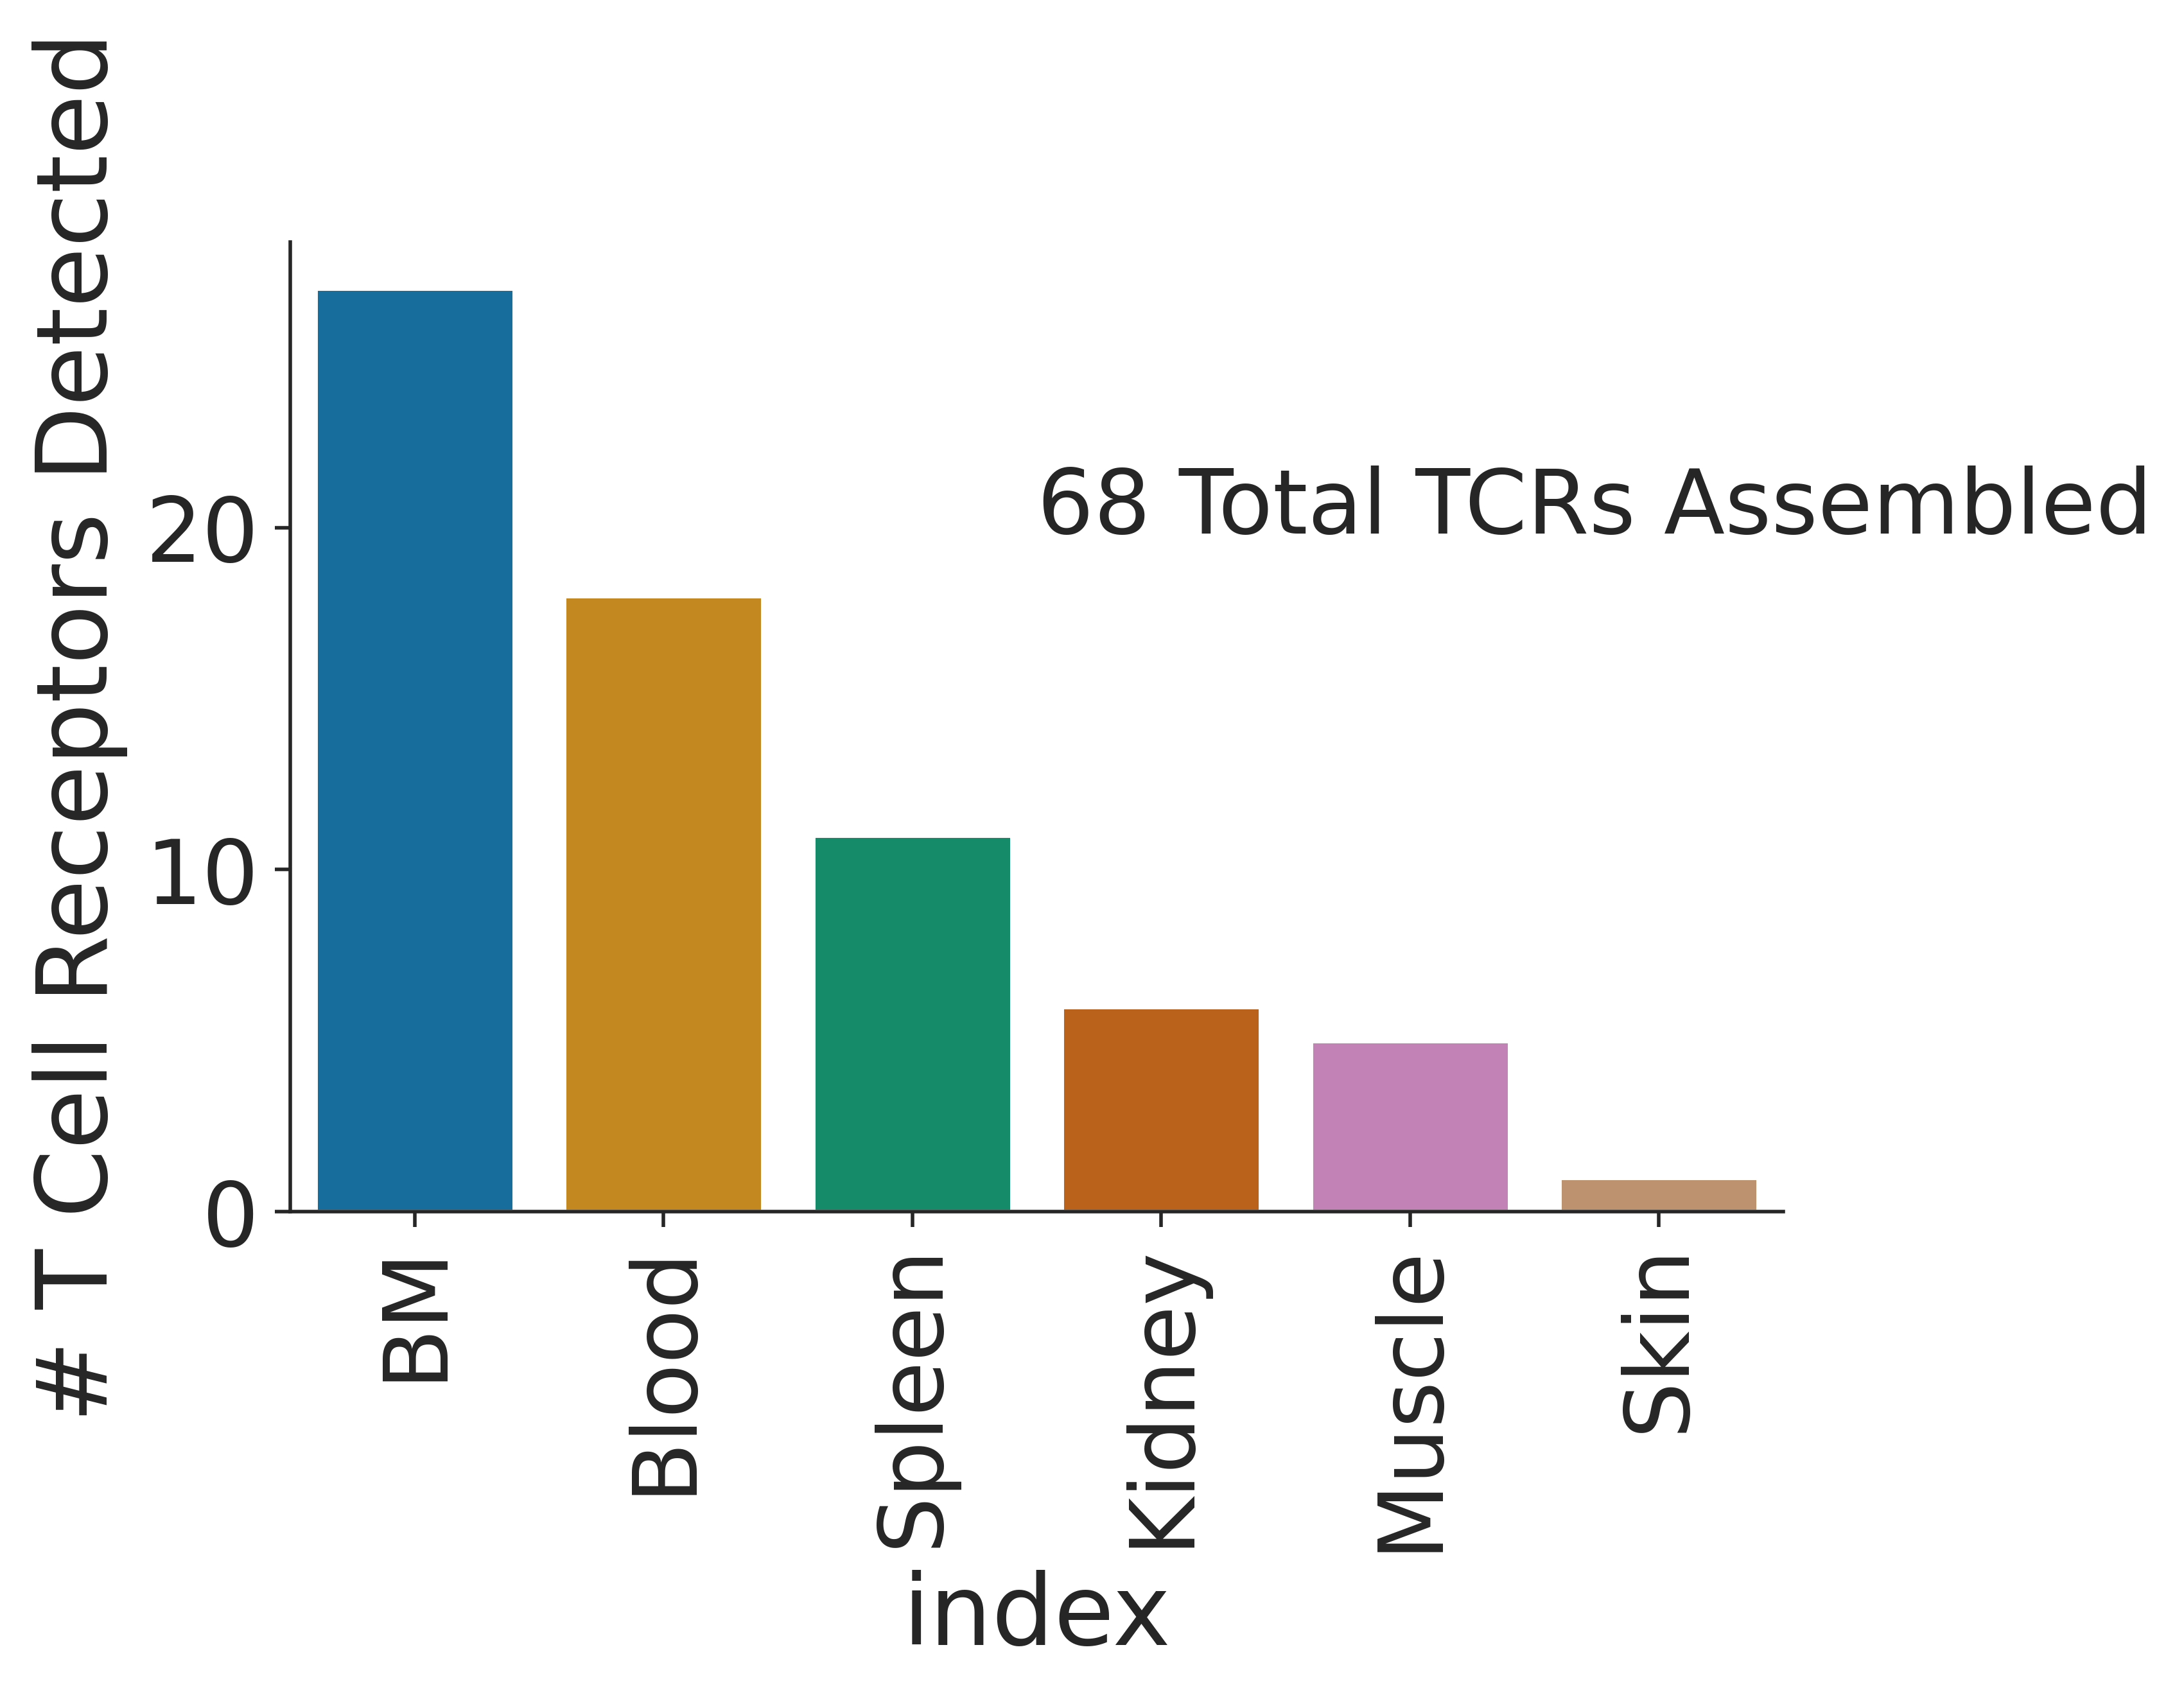

In [30]:
data = TCR_lineages[TCR_lineages.lineage == 428.0]

# Bar plot of T cells from different Tissues
_data = data.tissue.value_counts().reset_index()
fig, ax = plt.subplots(1,1)
sns.barplot(x = _data['index'], y = _data['tissue'])
plt.xticks(rotation = 90)
plt.ylabel('# T Cell Receptors Detected')
plt.text(0.5, 0.7, str(_data.tissue.sum()) + " Total TCRs Assembled",  transform=ax.transAxes)
sns.despine()